In [1]:
import numpy as np
import pandas as pd
import folium
import ast
import openrouteservice as ors
from dotenv import load_dotenv
import os
import branca.colormap as cm

load_dotenv()
ORSkey=os.environ['ORSkey']

In [2]:
locations = pd.read_csv("../foodstuffs-data/FoodstuffsLocations.csv")
locations.head()

Type    Location           Supermarket        Long        Lat
0  New World      Albany      New World Albany  174.710513 -36.728144
1  New World  Birkenhead  New World Birkenhead  174.711486 -36.811428
2  New World      Botany      New World Botany  174.911491 -36.933883
3  New World  Browns Bay  New World Browns Bay  174.747287 -36.715961
4  New World   Devonport   New World Devonport  174.796193 -36.829510

In [3]:
selected_saturday = pd.read_csv("../linear-program/output/SelectedRoutesSaturday.csv")
selected_saturday.head()

Route   TruckType  RouteCost  \
0  ['Warehouse', 'New World Papakura', "Pak 'n Sa...  OwnedTruck   294.5460   
1  ['Warehouse', 'New World Mt Roskill', 'New Wor...  OwnedTruck   192.6705   
2  ['Warehouse', "Pak 'n Save Wairau Road", 'New ...  OwnedTruck   332.3620   
3  ['Warehouse', 'New World Birkenhead', 'Four Sq...  OwnedTruck   432.4040   
4  ['Warehouse', 'Four Square Alberton', 'New Wor...  OwnedTruck   260.3805   

   Demand  
0      16  
1      11  
2      14  
3      15  
4      14

In [4]:
selected_weekday = pd.read_csv("../linear-program/output/SelectedRoutesWeekday.csv")
selected_weekday.head()

Route   TruckType   RouteCost  \
0  ['Warehouse', 'Four Square Glen Eden', "Pak 'n...  OwnedTruck  317.127667   
1  ['Warehouse', "Pak 'n Save Lincoln Road", 'War...  OwnedTruck  104.192500   
2  ['Warehouse', "Pak 'n Save Westgate", 'Warehou...  OwnedTruck  118.685417   
3  ['Warehouse', 'Four Square Everglade', 'New Wo...  OwnedTruck  271.918833   
4  ['Warehouse', 'Four Square Alberton', 'Four Sq...  OwnedTruck  387.919750   

   Demand  
0      16  
1       9  
2       9  
3      15  
4      16

In [5]:
def initialise_map(locations):
    """ Initialise map and plot store locations.

        Parameters
        ----------
        locations : dataframe
            Location of stores.
        
        Returns
        -------
        m : object
            Map object with plotted store locations.
    """
    coords = locations[['Long', 'Lat']] # Mapping packages work with Long, Lat arrays
    coords = coords.to_numpy().tolist() # Make the arrays into a list of lists.
    # Folium, however, requires Lat, Long arrays - so a reversal is needed.
    # coords[0] is the warehouse
    m = folium.Map(location = list(reversed(coords[2])), zoom_start=10.25)
    for i in range(len(locations)):
        if locations.Type[i] == "Four Square":
            icon_url = "images/store_green.png"
        elif locations.Type[i] == "New World":
            icon_url = "images/store_red.png"
        elif locations.Type[i] == "Pak 'n Save":
            icon_url = "images/store_orange.png"
        elif locations.Type[i] == "Warehouse":
            icon_url = "images/warehouse.png"
        icon = folium.features.CustomIcon(icon_url, icon_size=(16, 16))
        folium.Marker(
            list(reversed(coords[i])),
            popup = locations.Supermarket[i],
            icon = icon # folium.Icon(color = iconCol)
        ).add_to(m)
    return m

In [6]:
def find_driving_route(coords):
    """ Find driving route between stores in a route.

        Parameters
        ----------
        coords : list
            List of coordinates of store locations within route.
        
        Returns
        -------
        object
            Driving route.
    """
    client = ors.Client(key=ORSkey)
    
    return client.directions(
        coordinates = coords,
        profile = 'driving-hgv', # can be driving-car, driving-hgv, etc.
        format='geojson',
        validate = False
    )

In [7]:
def plot_routes(locations, routes, m, col="RouteCost", min=None, max=None):
    """ Plot driving routes of selected routes between stores.

        Parameters
        ----------
        locations : dataframe
            Locations of nodes.
        routes : dataframe
            Selected routes.
        m : object
            Map object.
        
        Returns
        -------
        m : object
            Map object with plotted routes.
    """
    colour_choices = cm.LinearColormap(
        colors=["green", "blue", "purple"],
        vmin=min if min is not None else min(routes[col]),
        vmax=max if max is not None else max(routes[col])
    )

    for i in routes.index:
        route = ast.literal_eval(routes.Route[i])
        
        coord_list = []
        for node in route:
            coord = locations[locations.Supermarket==node][['Long', 'Lat']]
            coord = coord.to_numpy().tolist()
            coord_list.append(coord[0])
        
        driving_route = find_driving_route(coord_list)
        coordinates = driving_route['features'][0]['geometry']['coordinates']
        folium.PolyLine(
            locations=[list(reversed(coord)) for coord in coordinates],
            opacity=0.5,
            weight=4,
            color=colour_choices(routes[col][i])
        ).add_to(m)
    return m


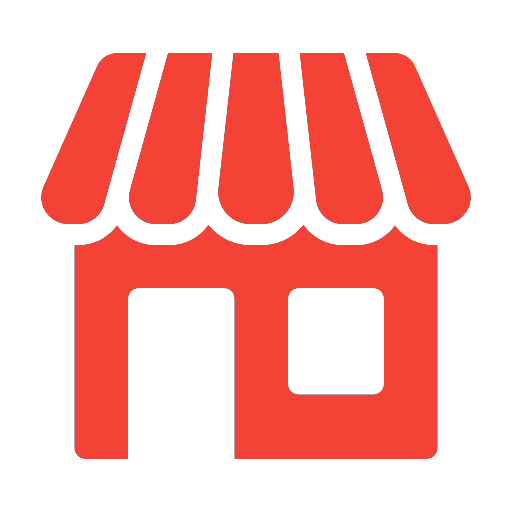
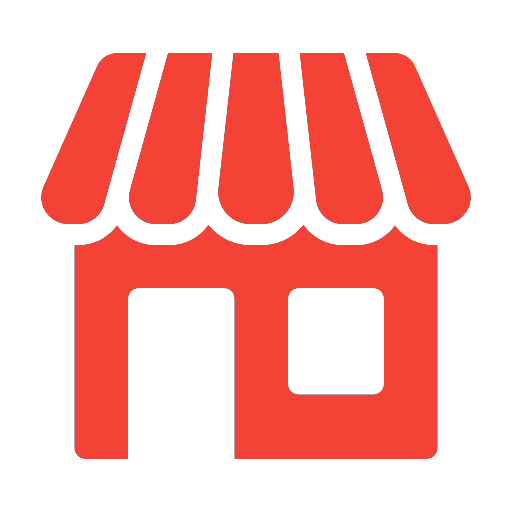
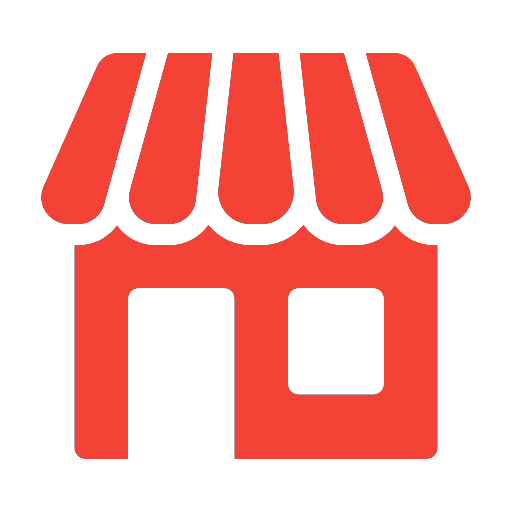
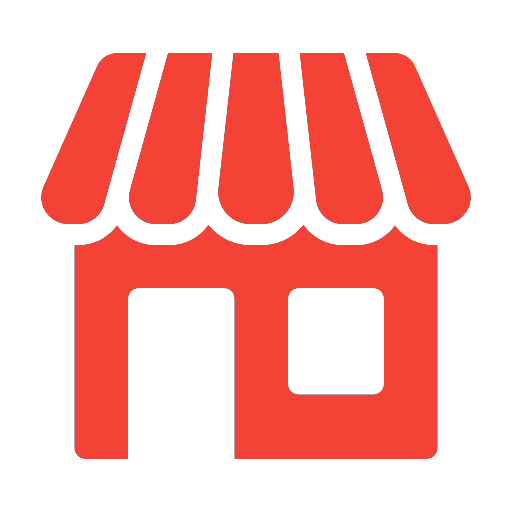
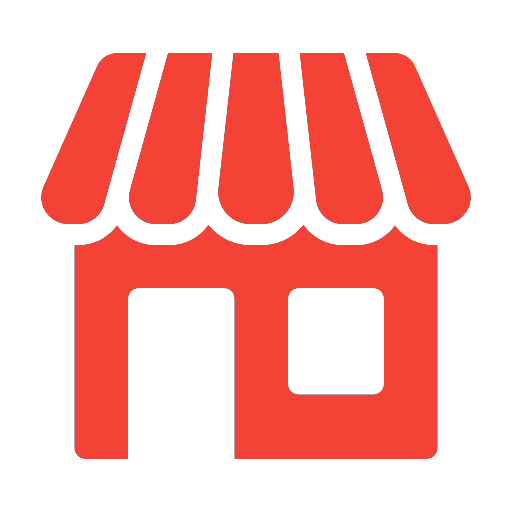
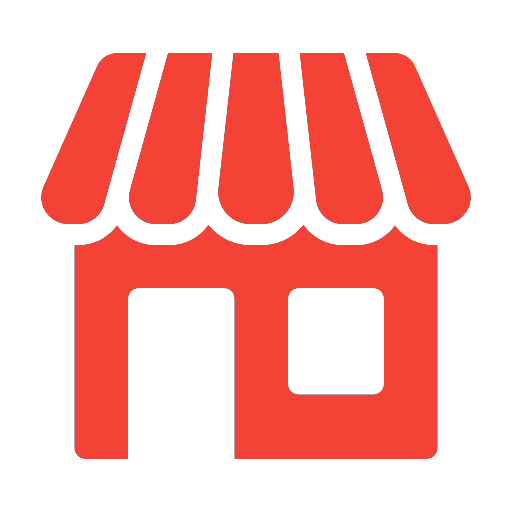
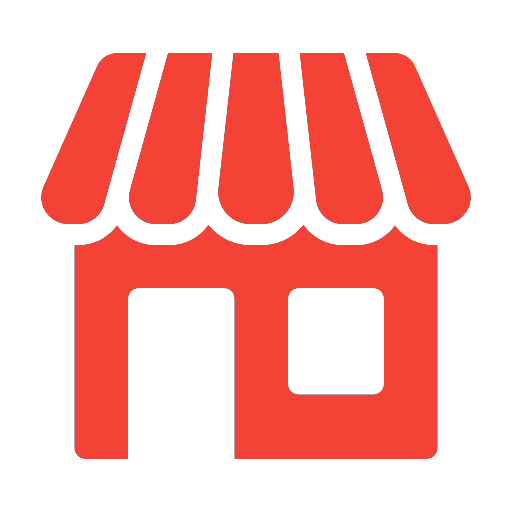
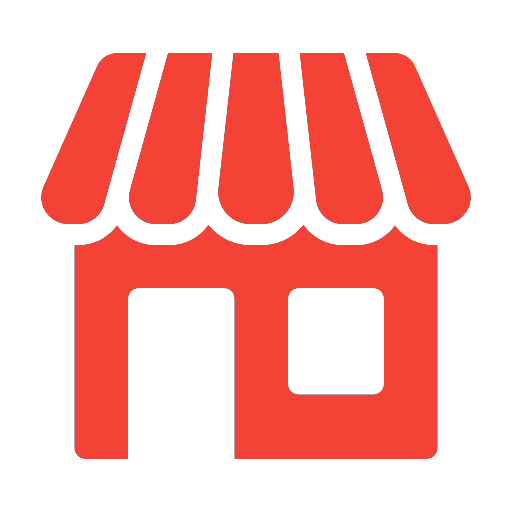
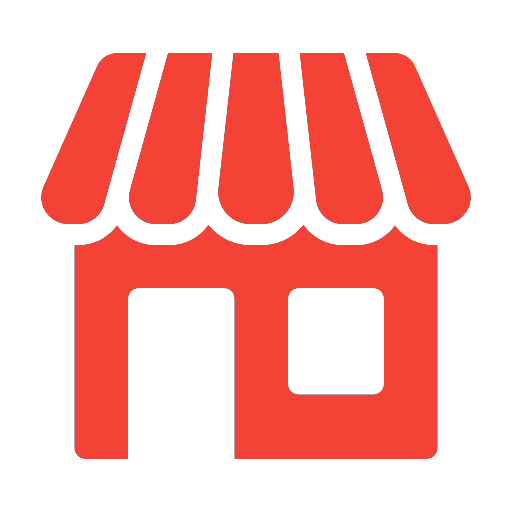
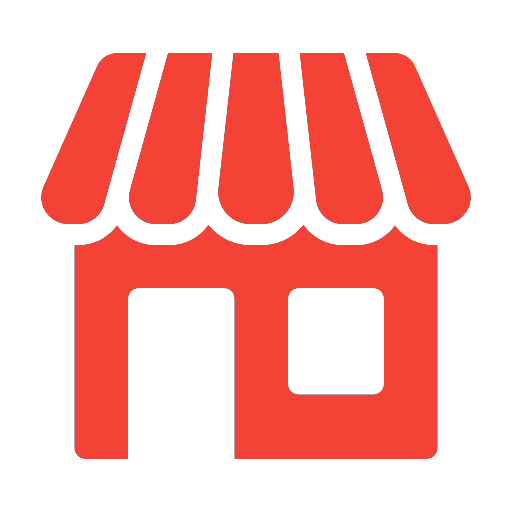
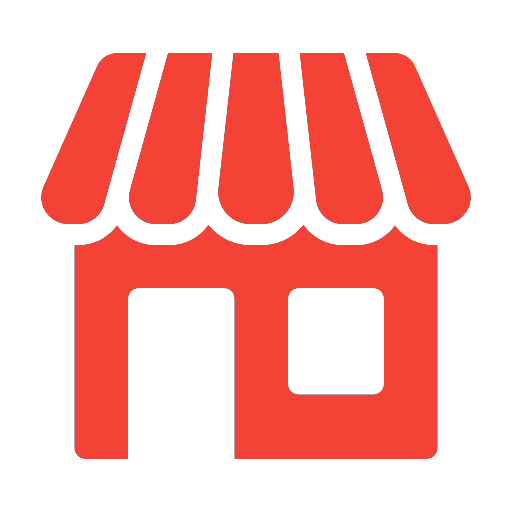
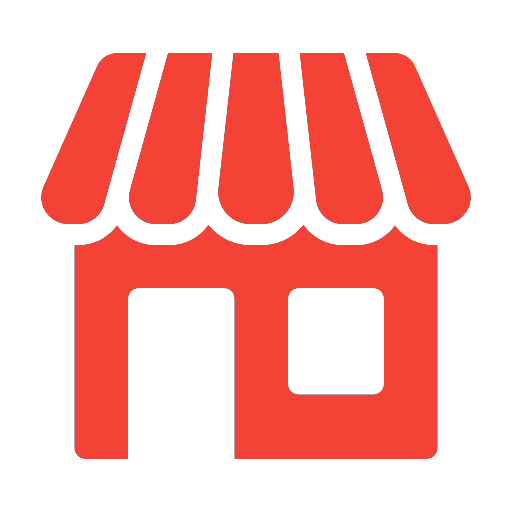
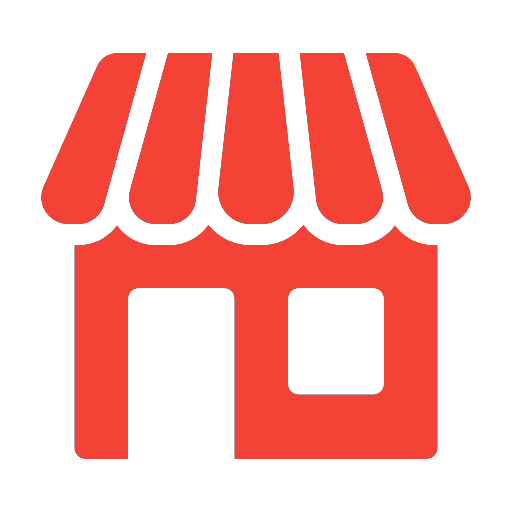
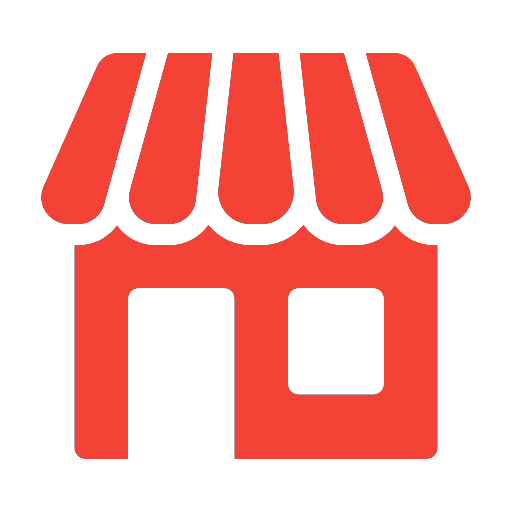
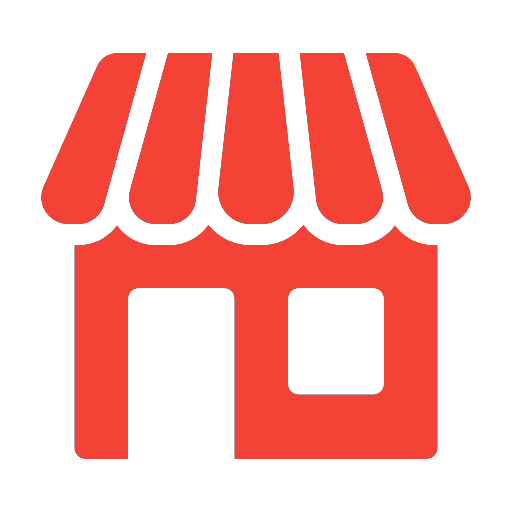
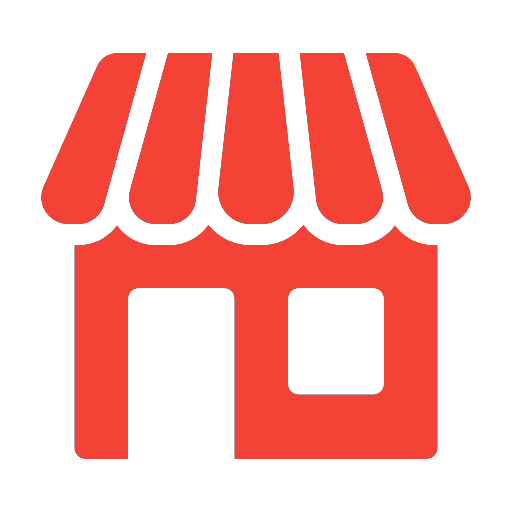
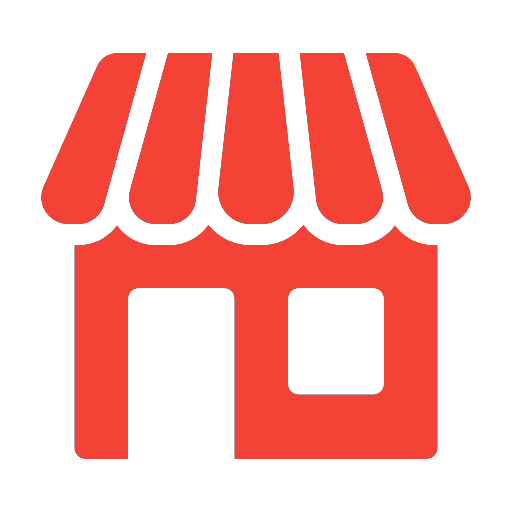
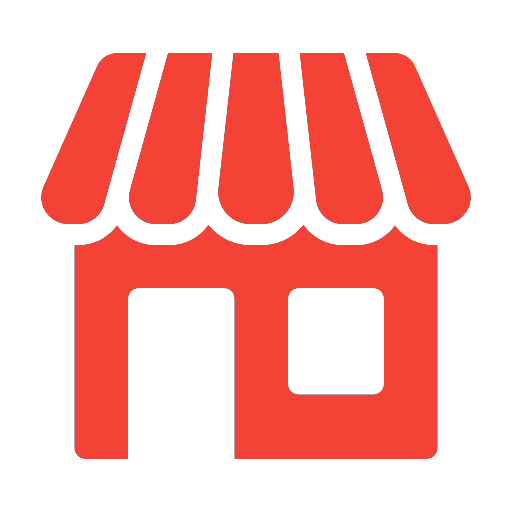
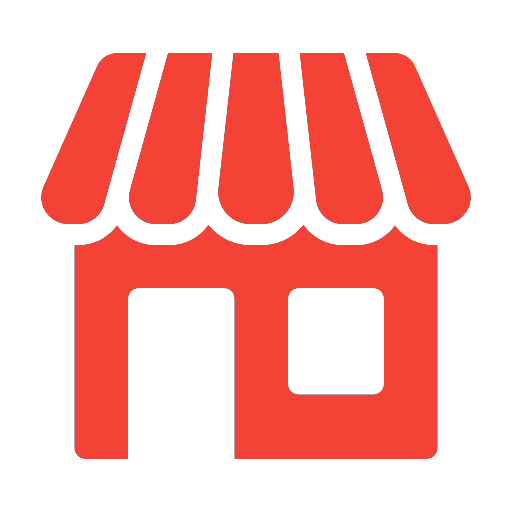
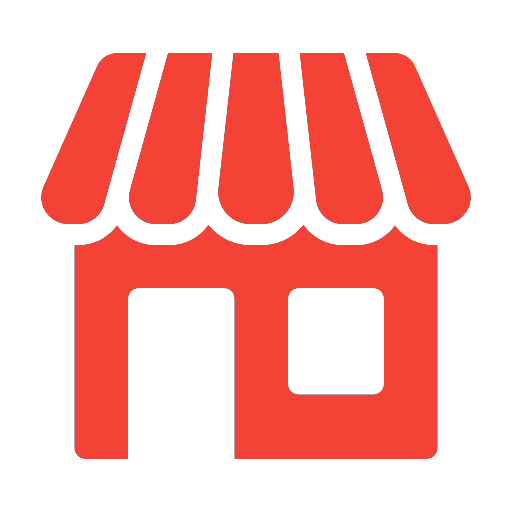
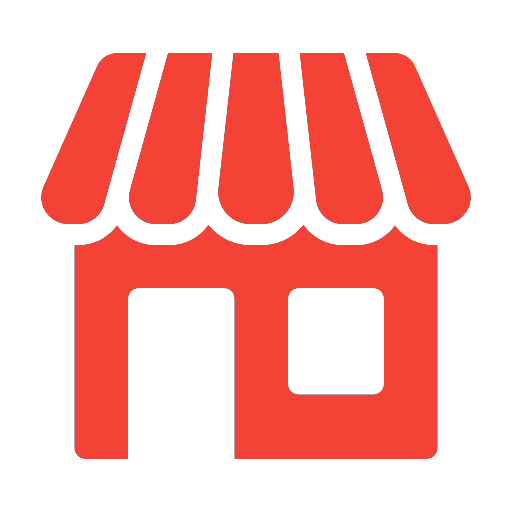
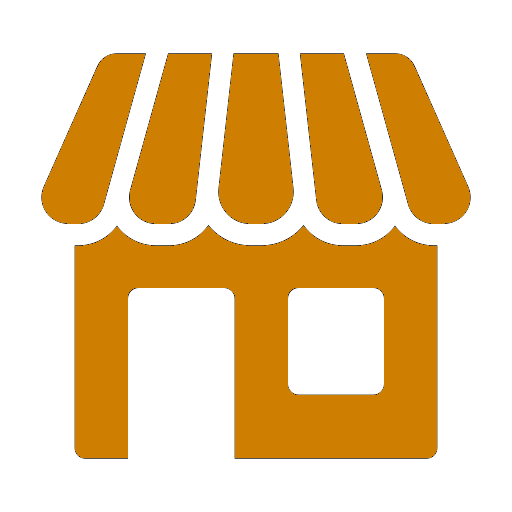
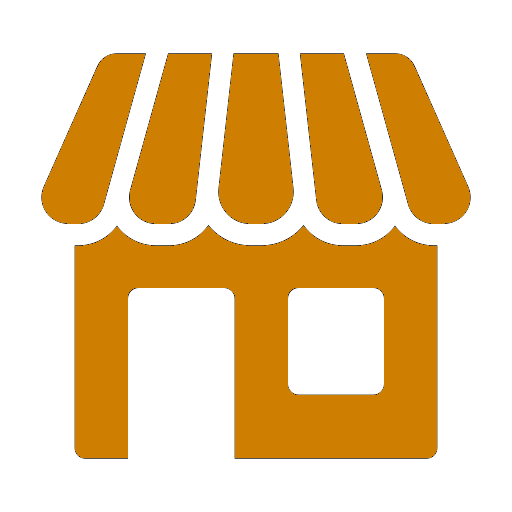
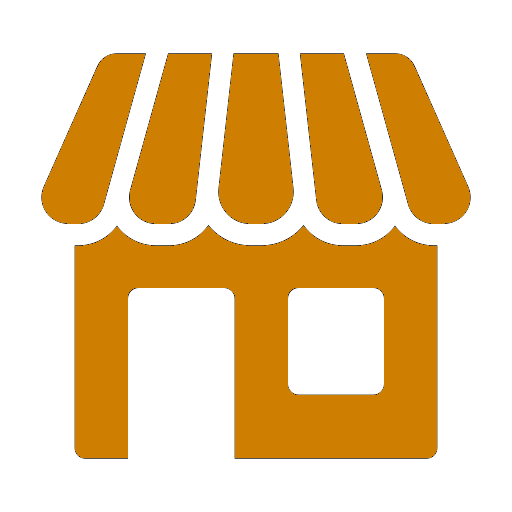
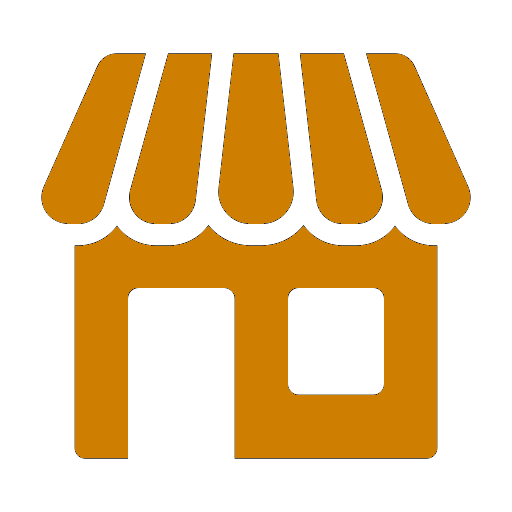
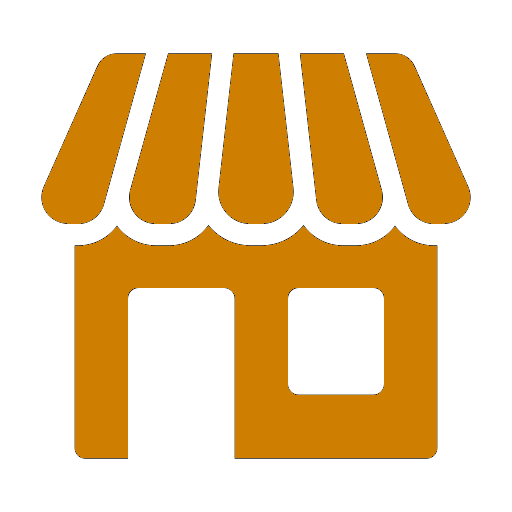
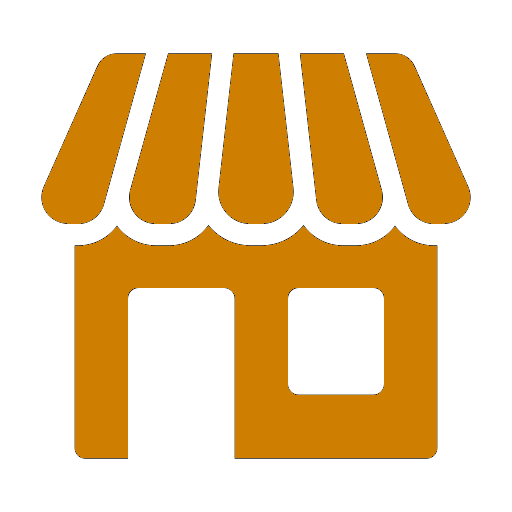
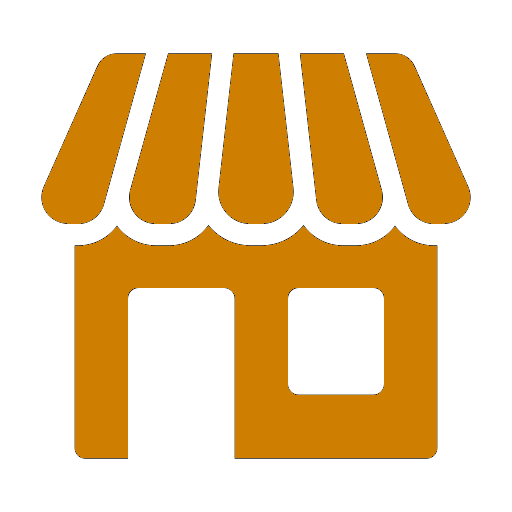
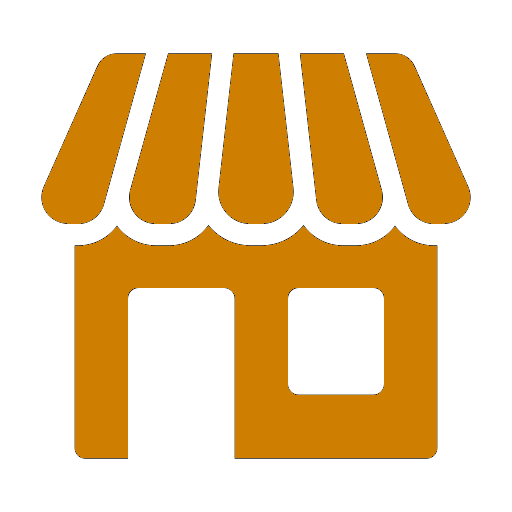
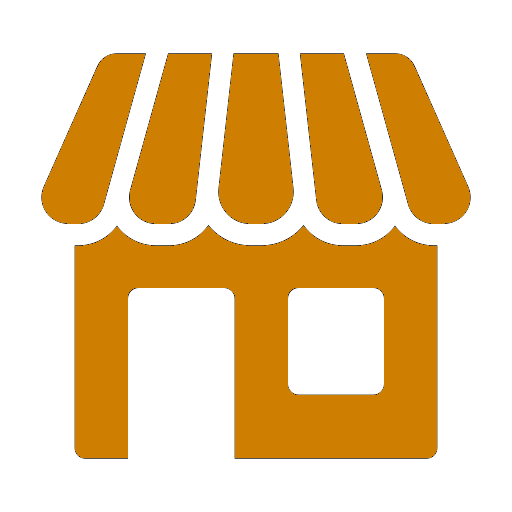
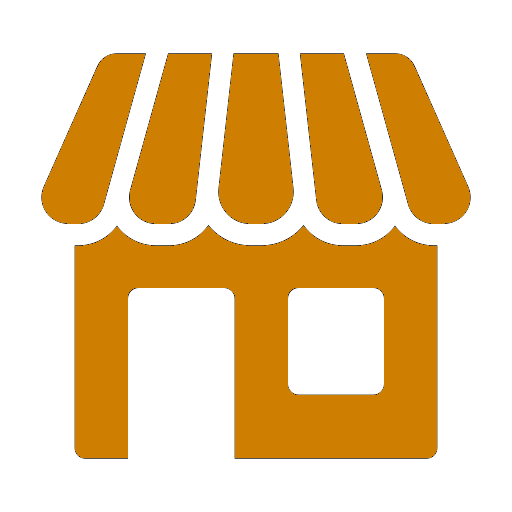
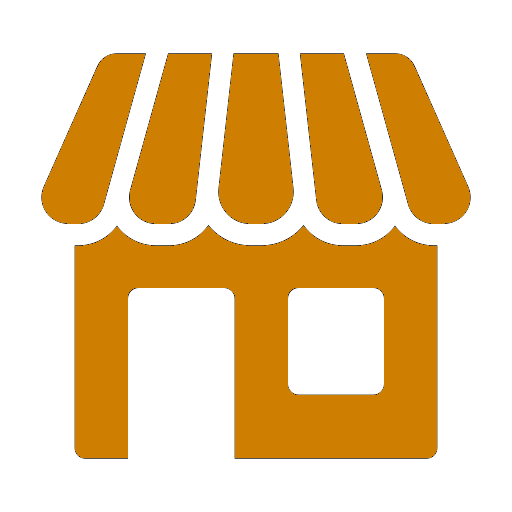
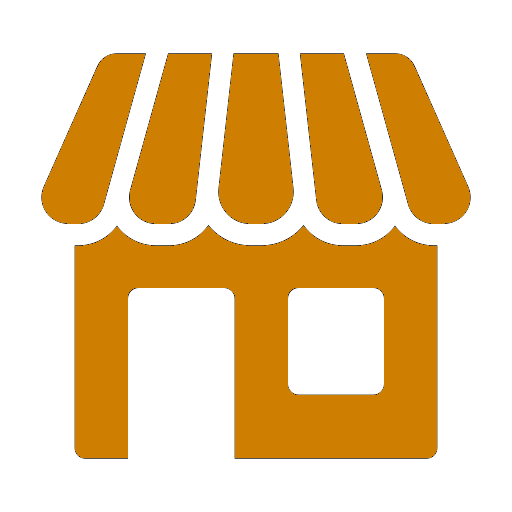
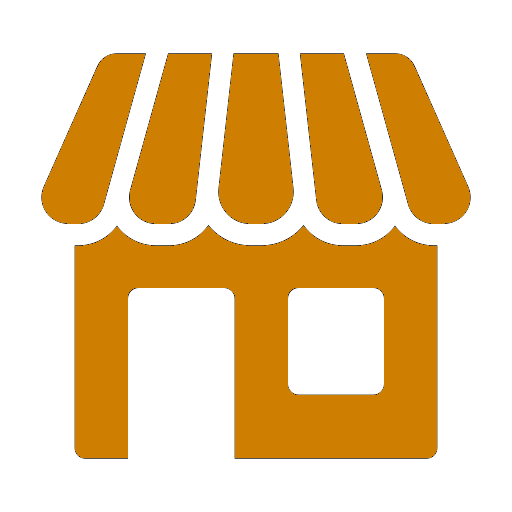
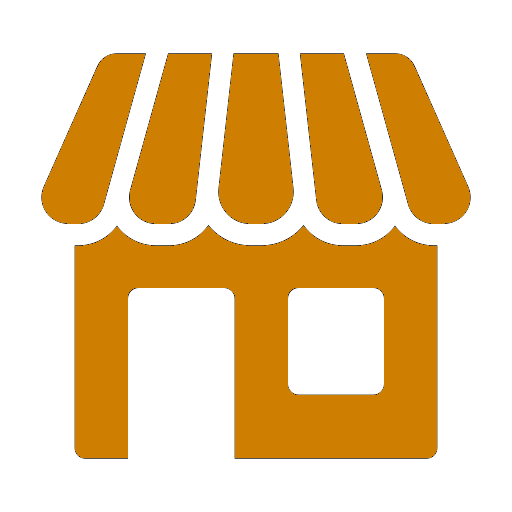
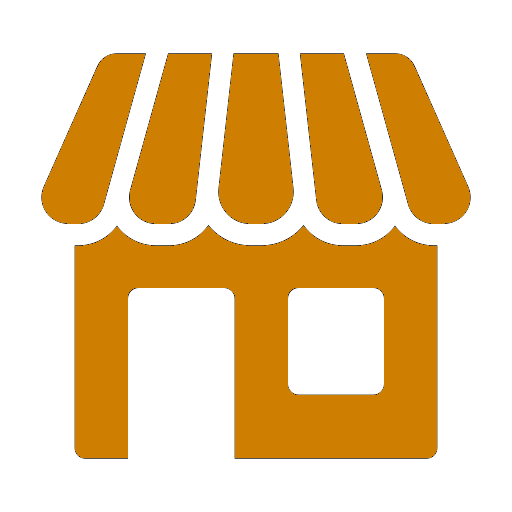
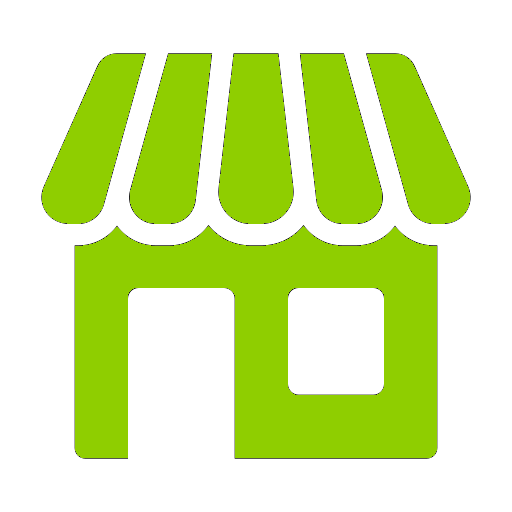
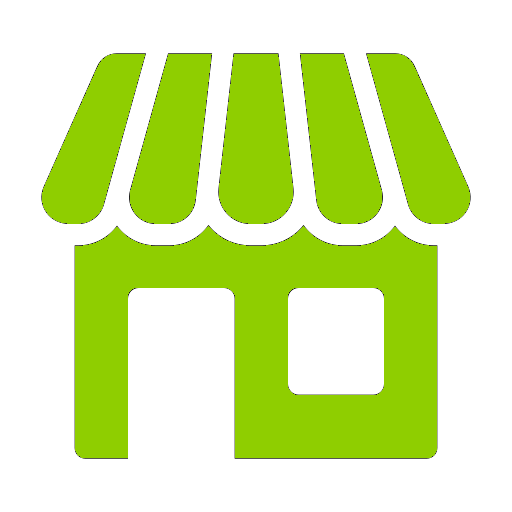
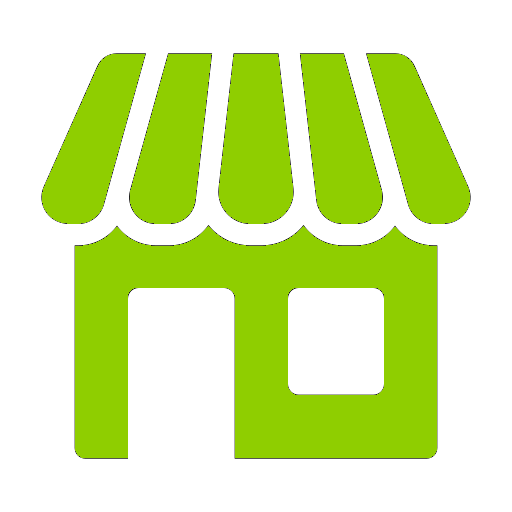
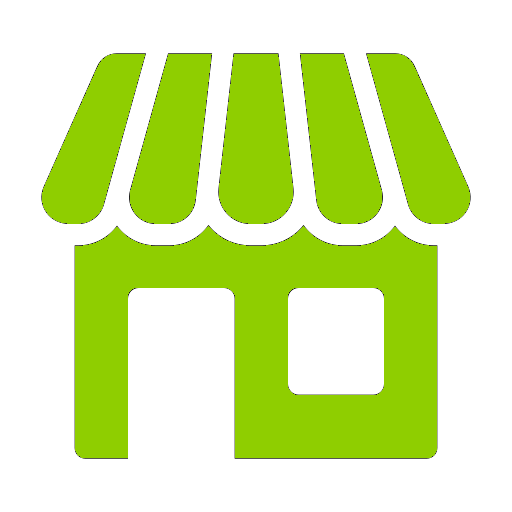
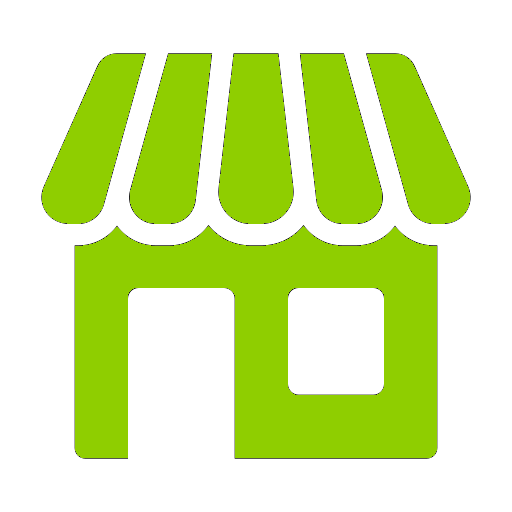
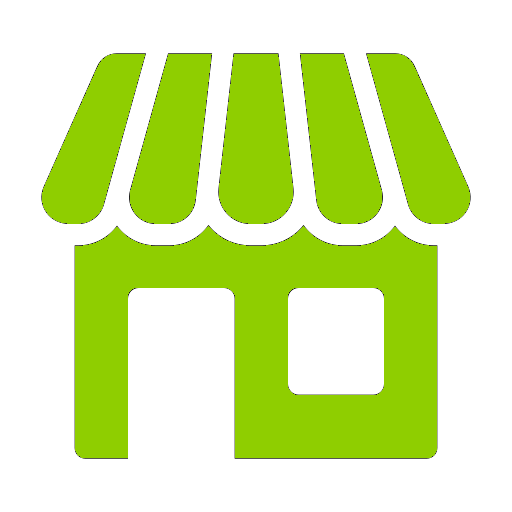
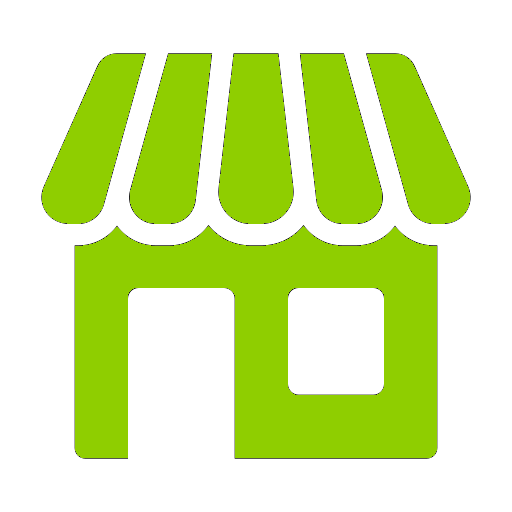
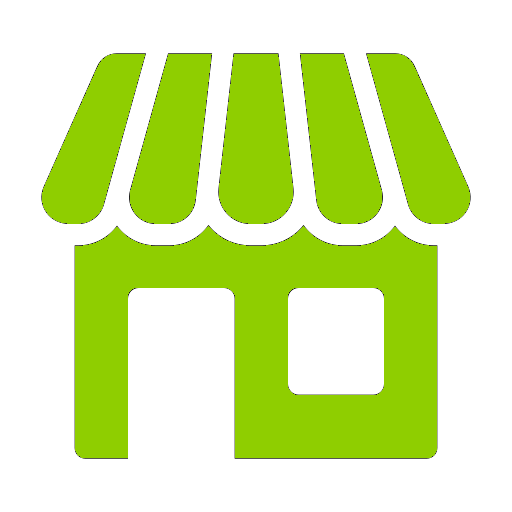
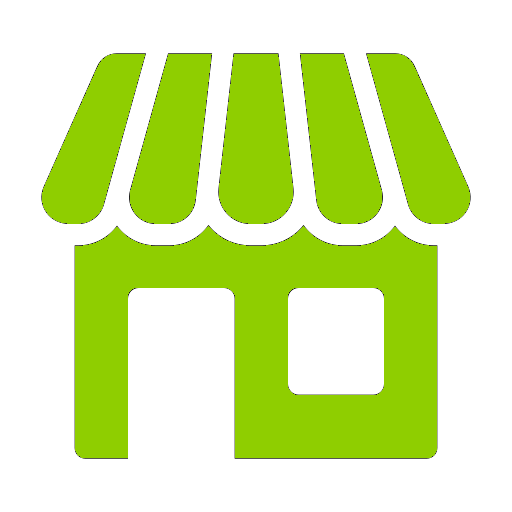
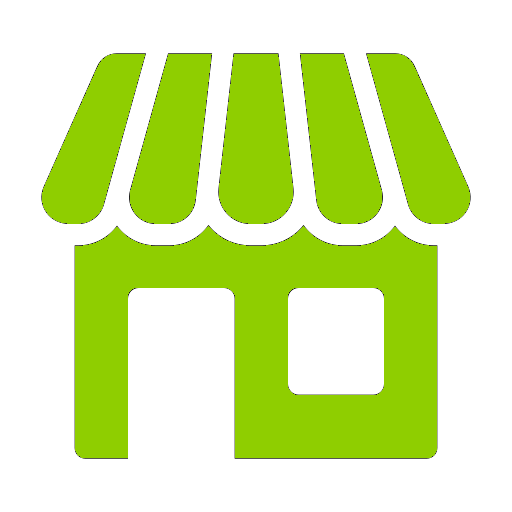
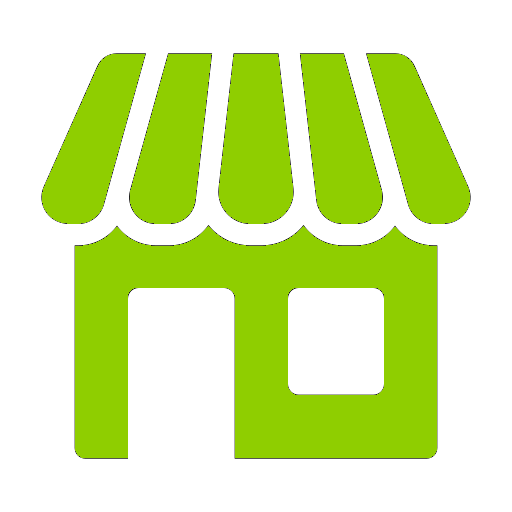
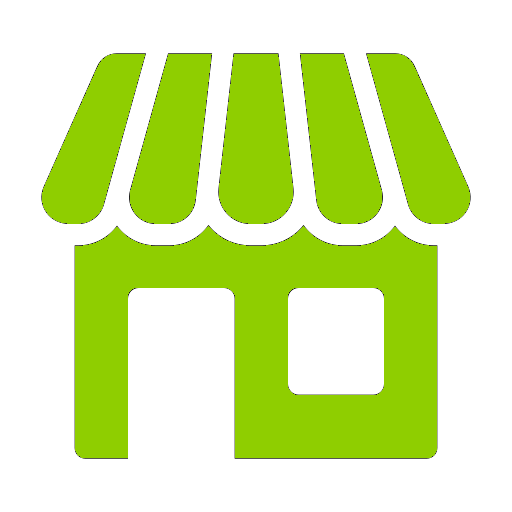
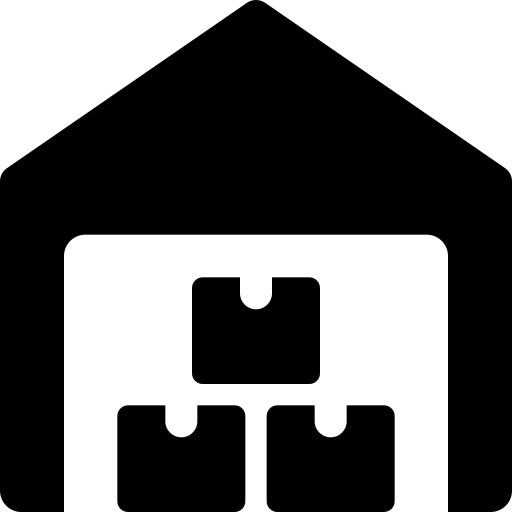

In [8]:
initialise_map(locations)

In [9]:
combined_costs = pd.concat([selected_saturday.RouteCost, selected_weekday.RouteCost])
min_cost = min(combined_costs)
max_cost = max(combined_costs)


In [10]:
combined_demands = pd.concat([selected_weekday.Demand, selected_saturday.Demand])
min_demand = min(combined_demands)
max_demand = max(combined_demands)


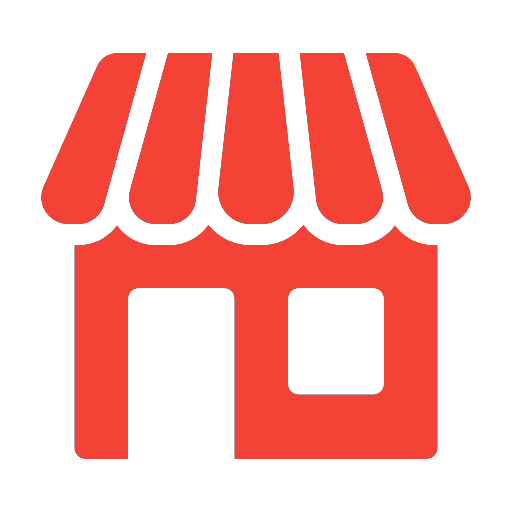
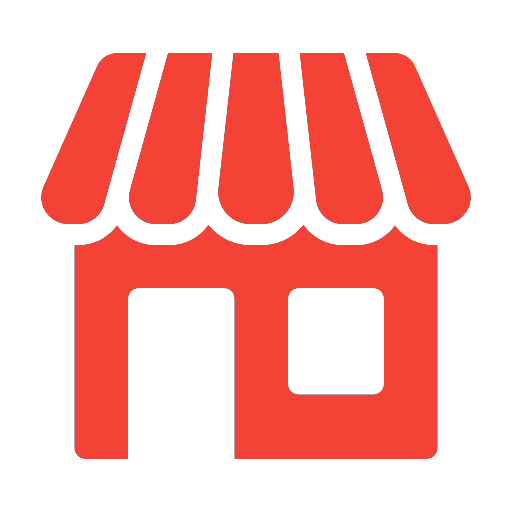
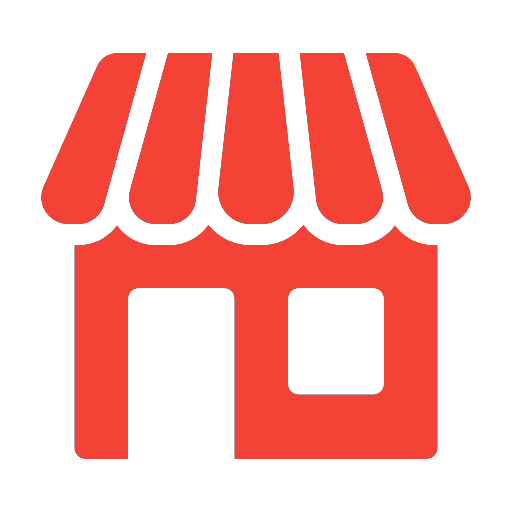
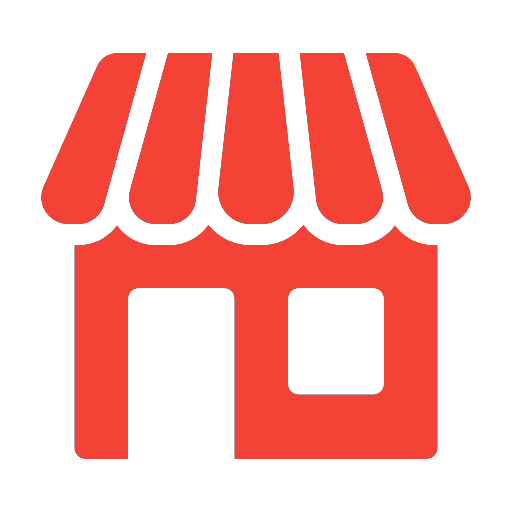
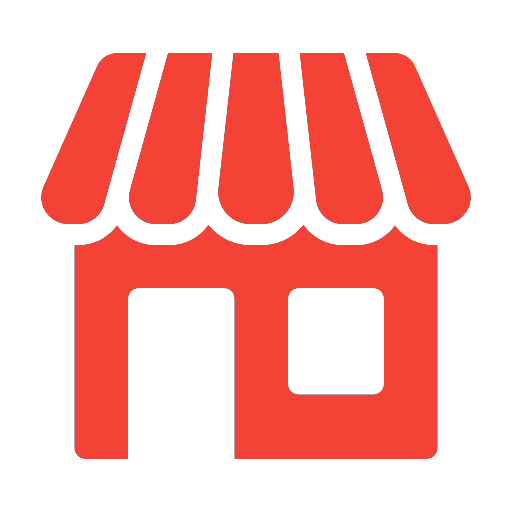
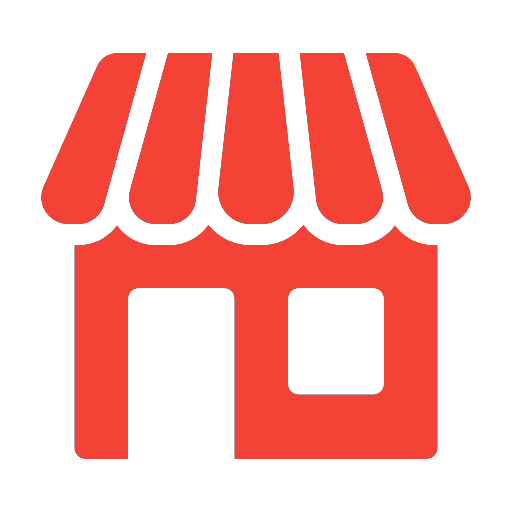
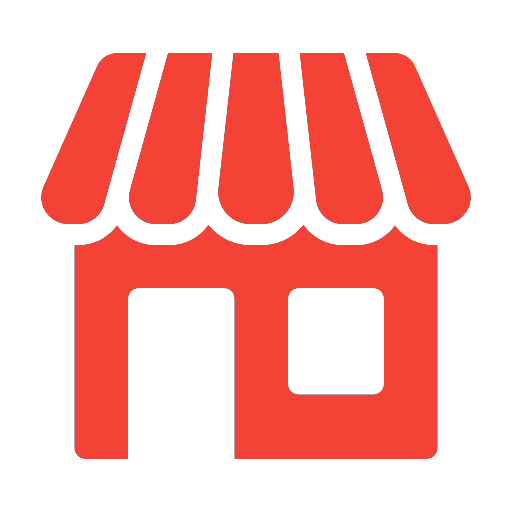
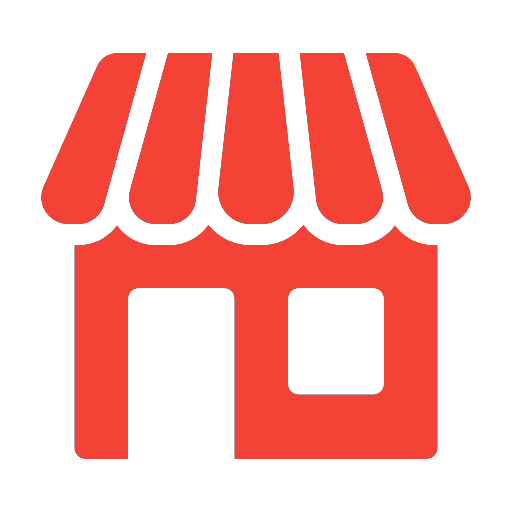
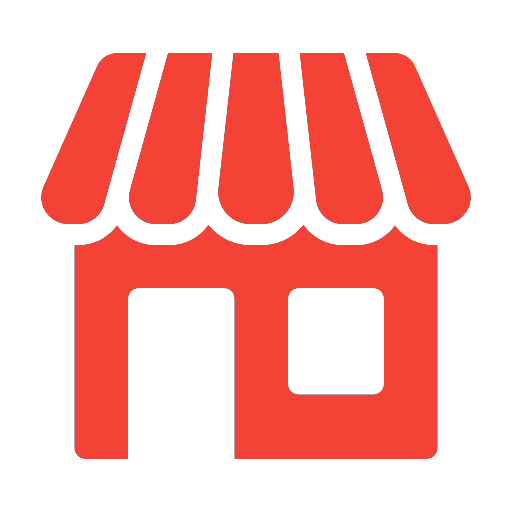
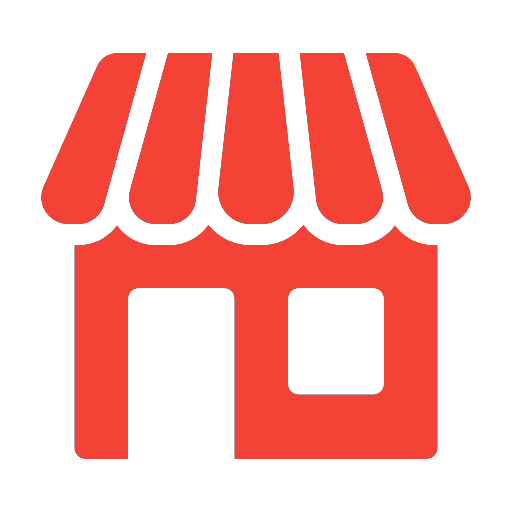
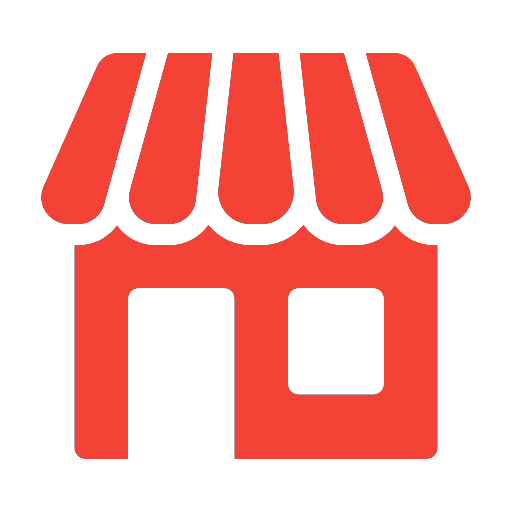
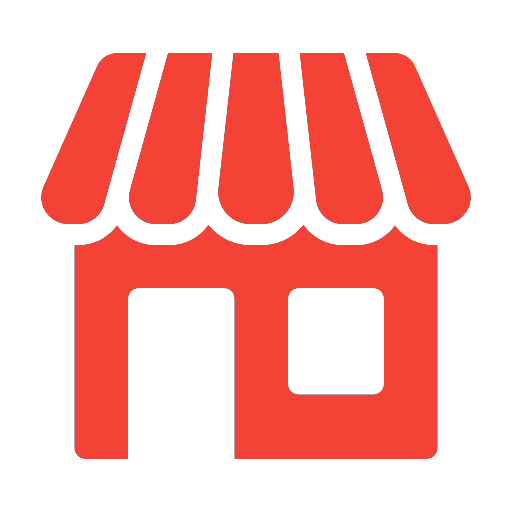
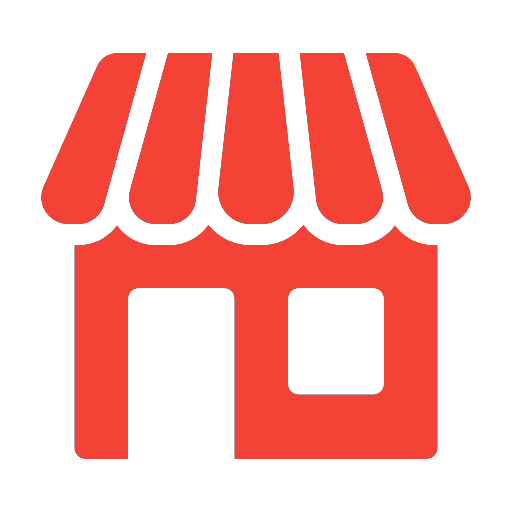
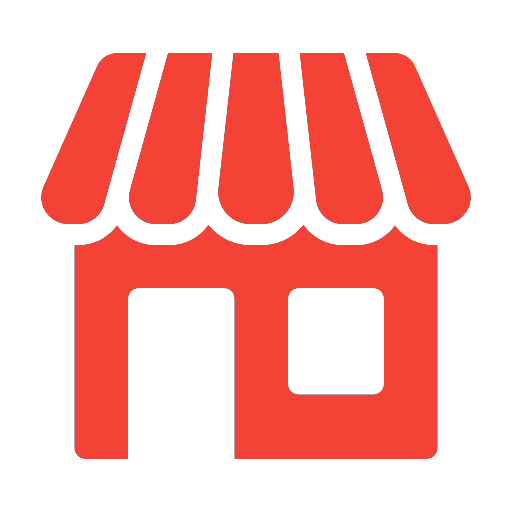
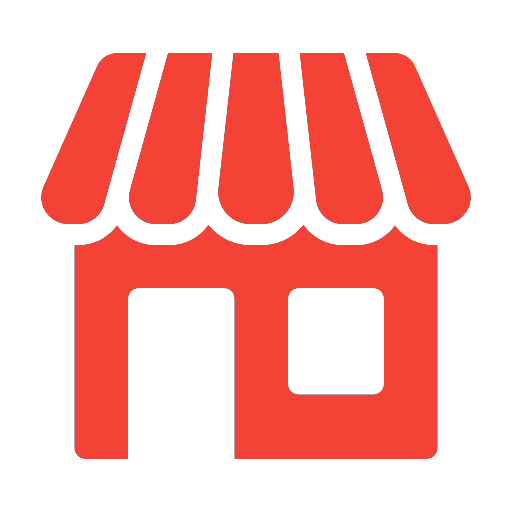
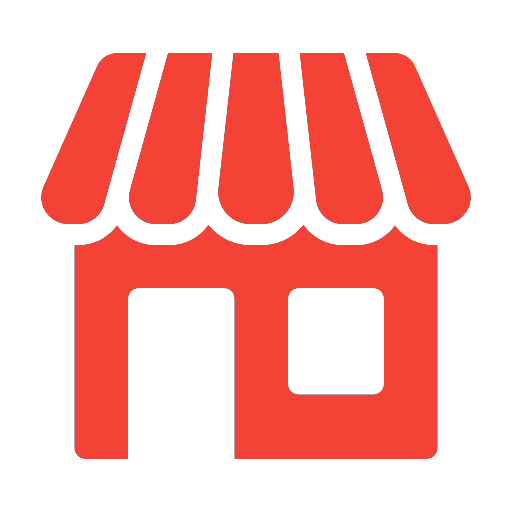
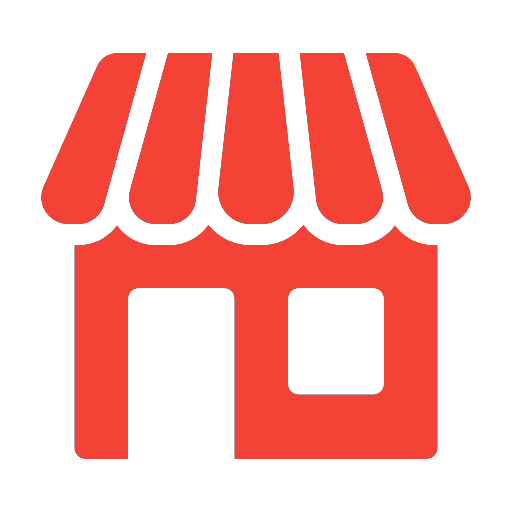
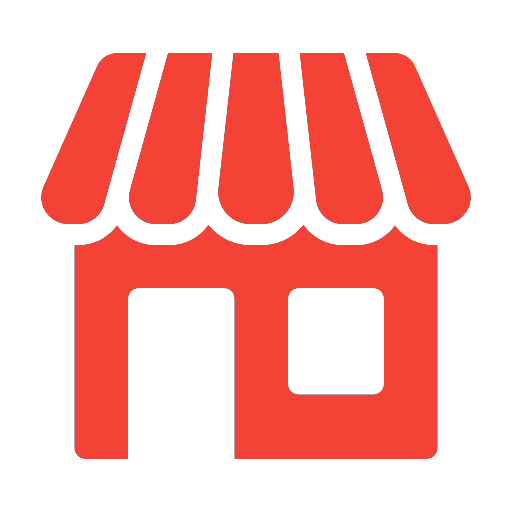
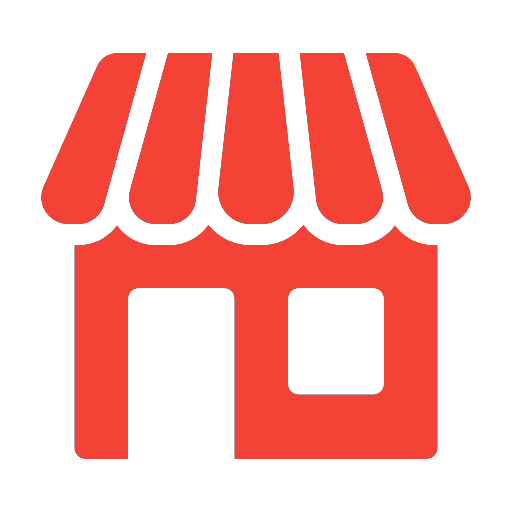
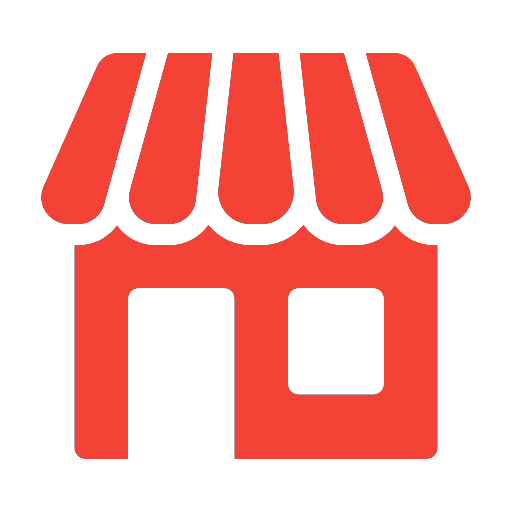
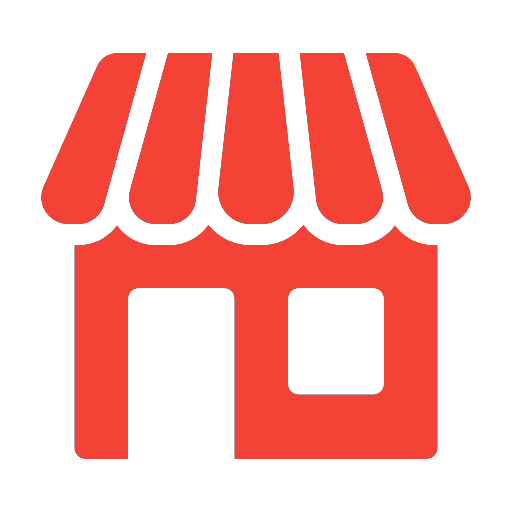
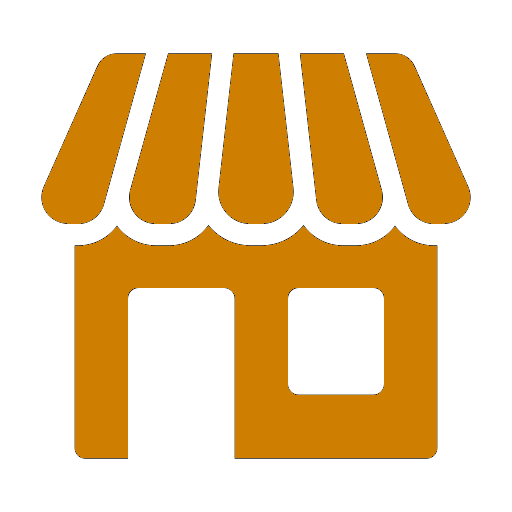
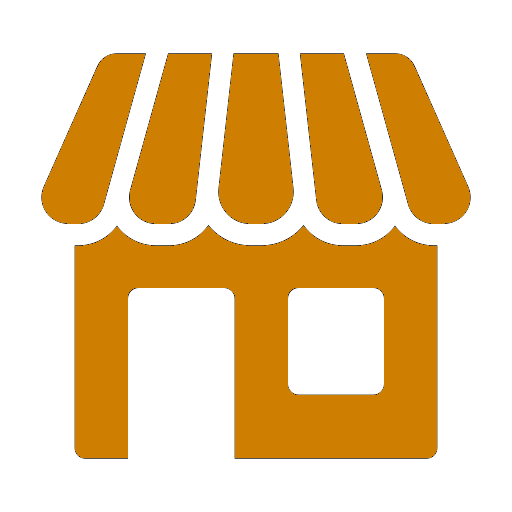
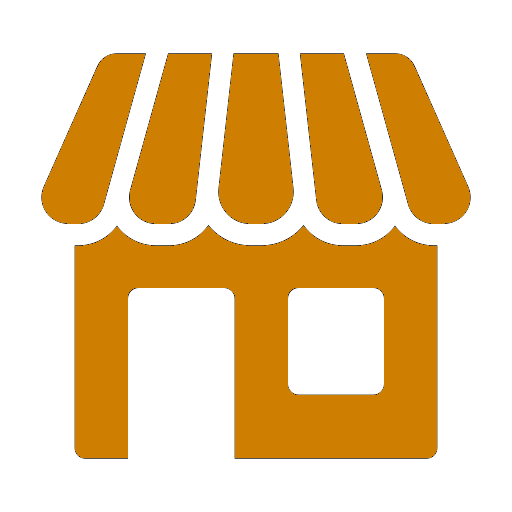
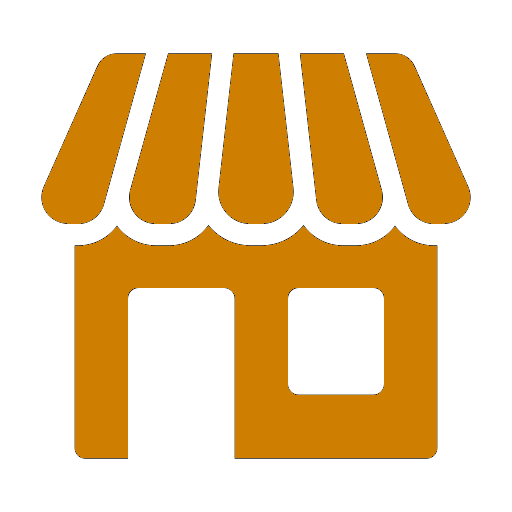
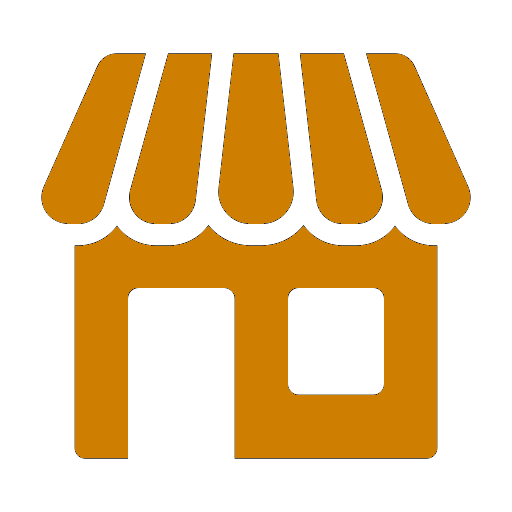
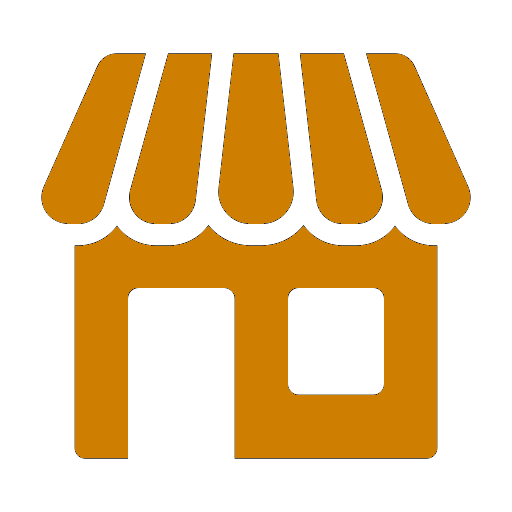
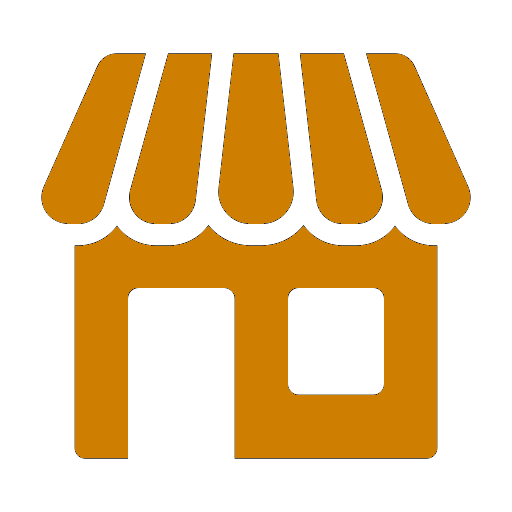
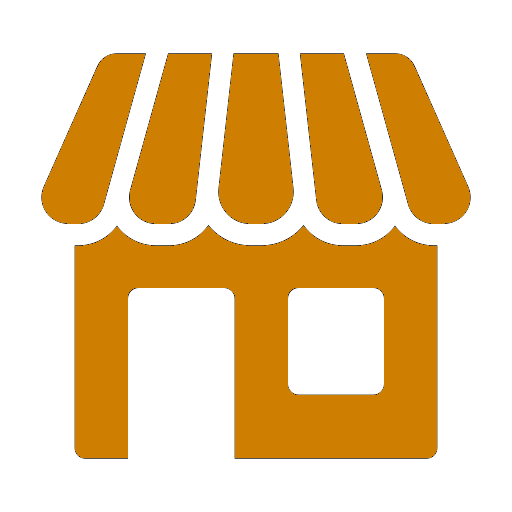
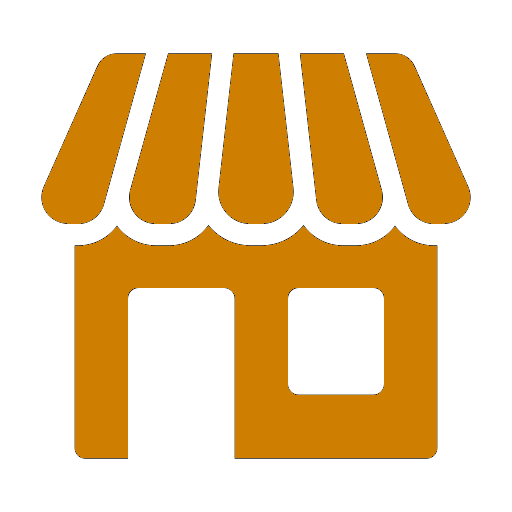
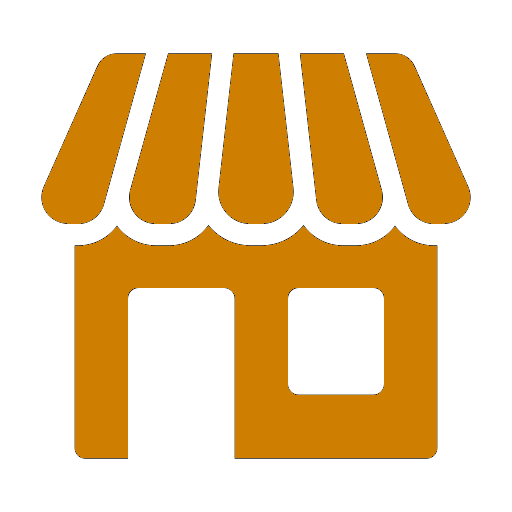
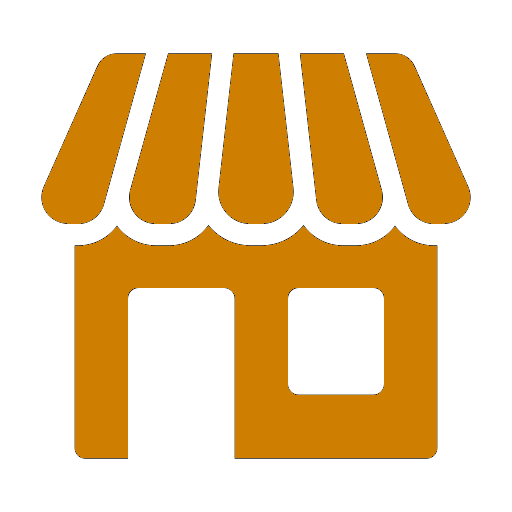
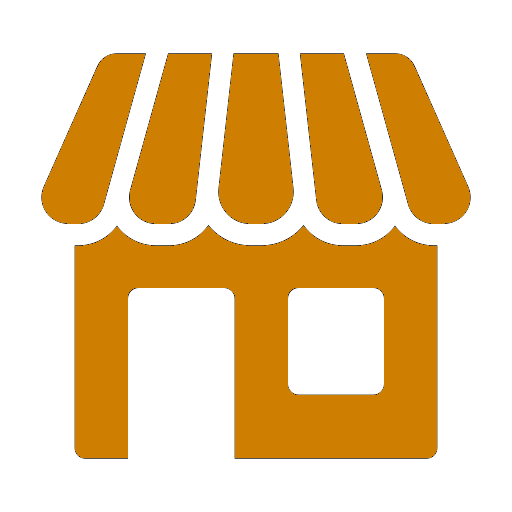
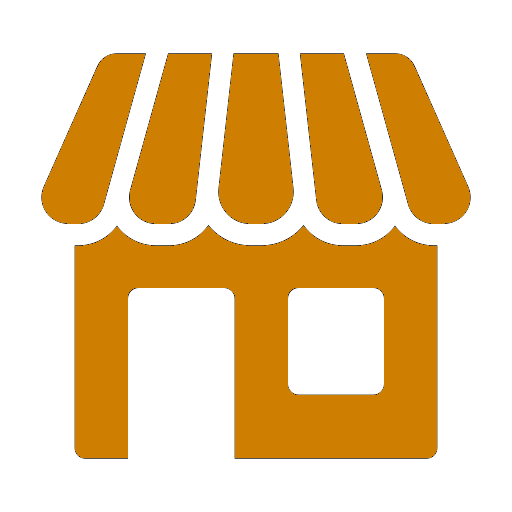
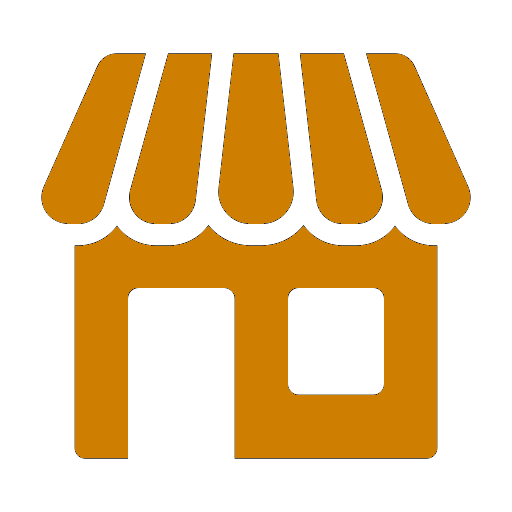
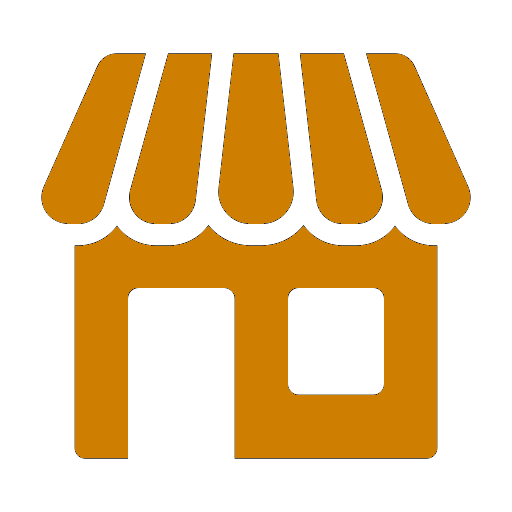
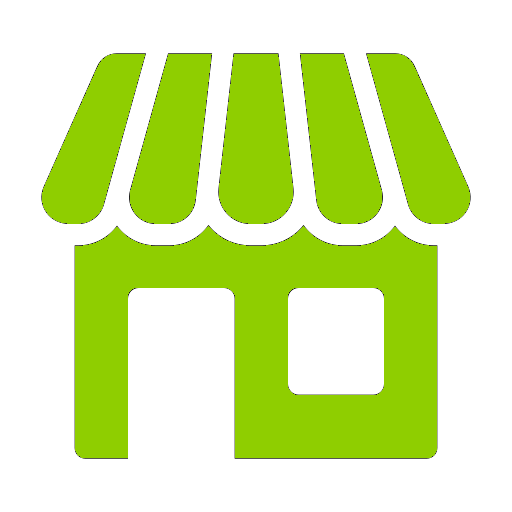
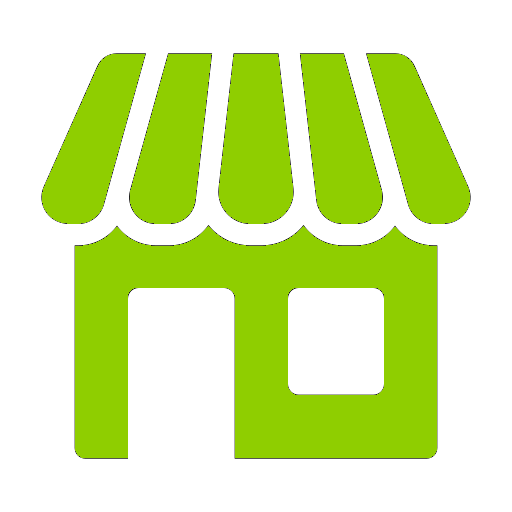
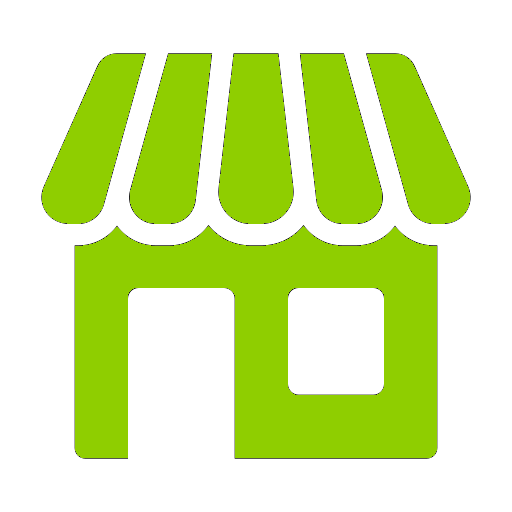
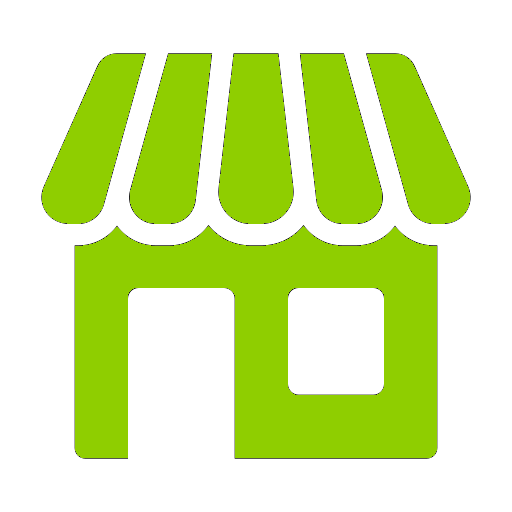
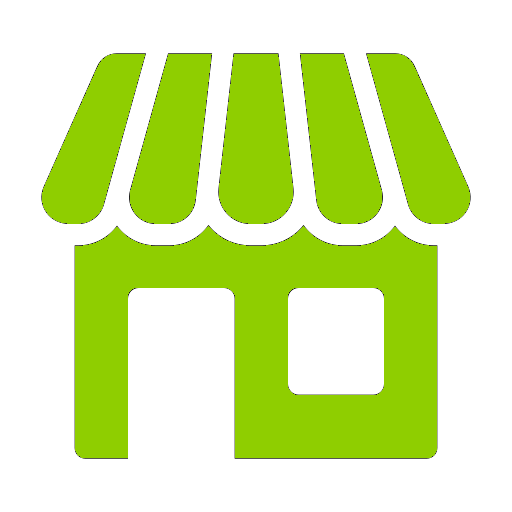
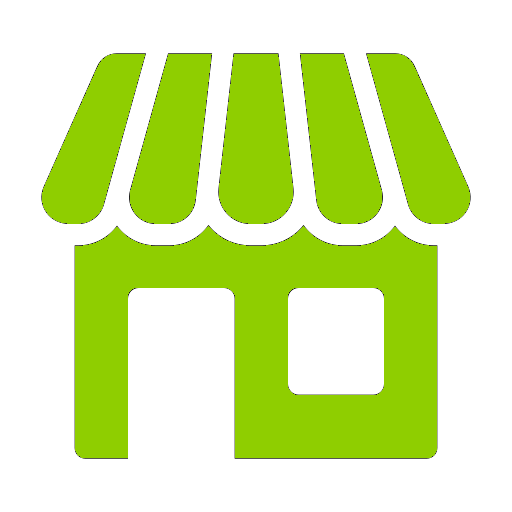
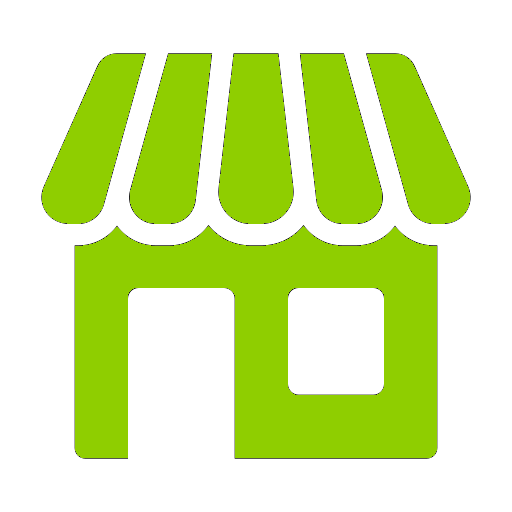
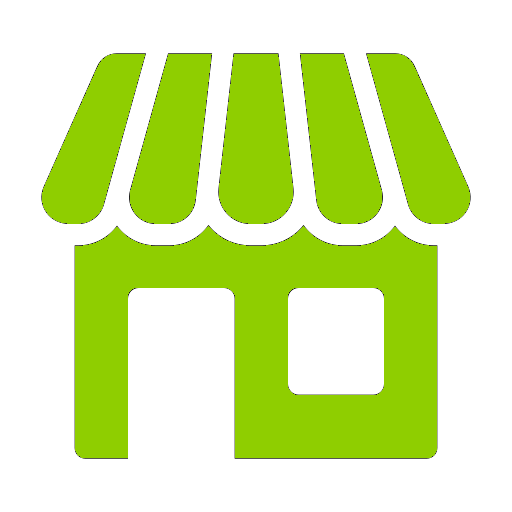
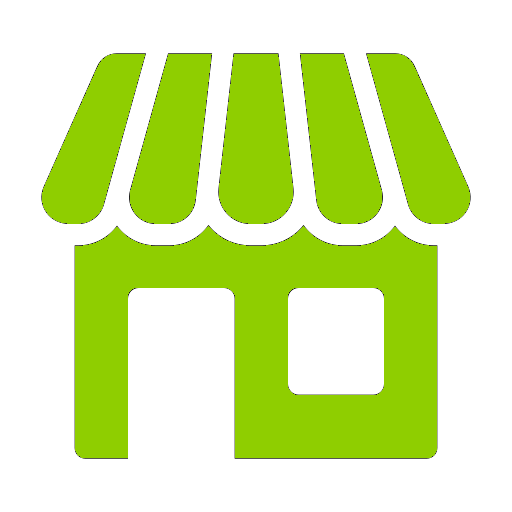
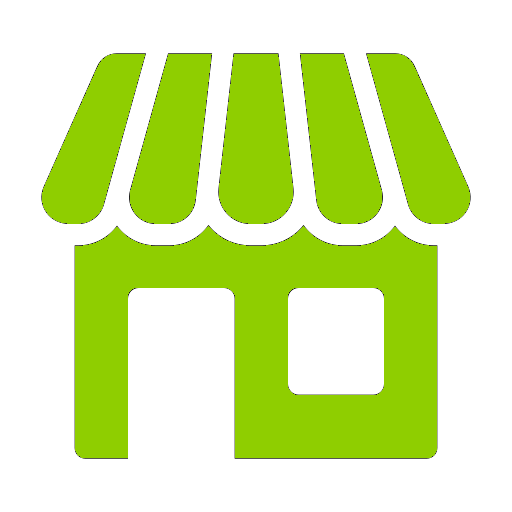
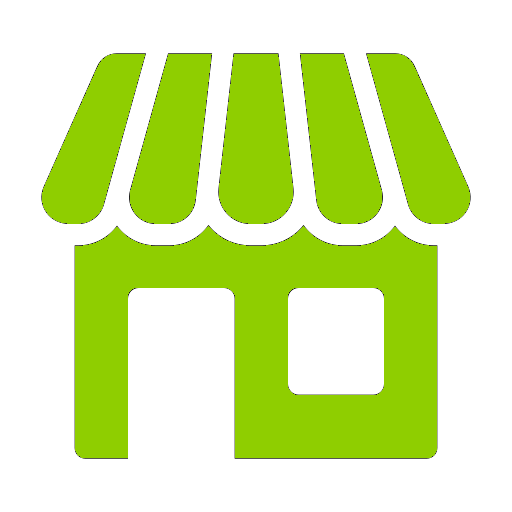
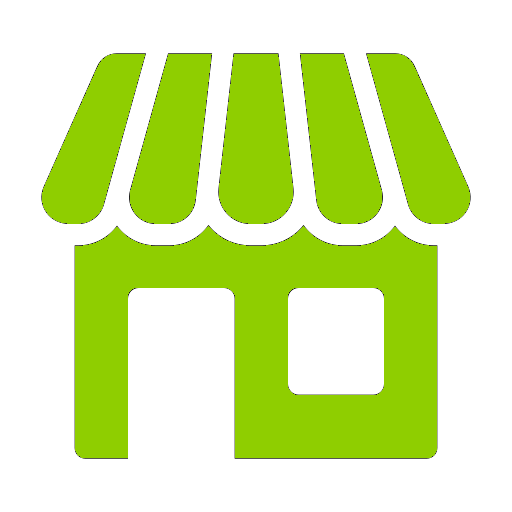
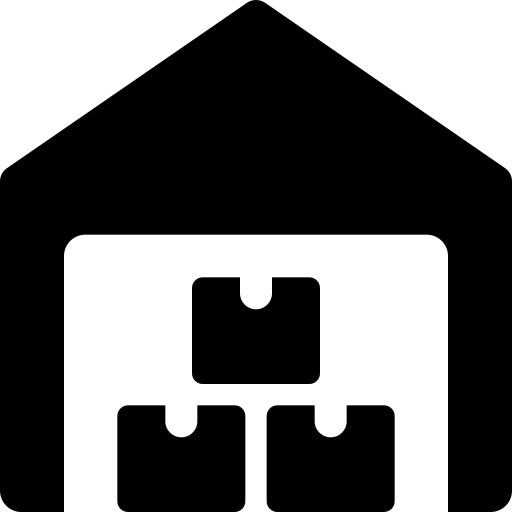

In [11]:
# plot map of Saturday routes coloured by route costs
saturday_map_costs = initialise_map(locations)
plot_routes(locations, selected_saturday, saturday_map_costs, min=min_cost, max=max_cost)


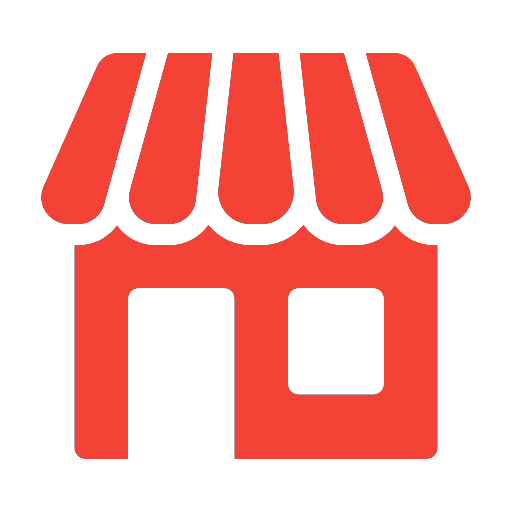
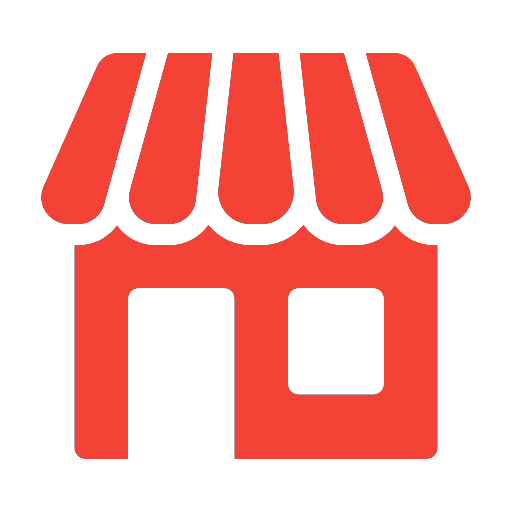
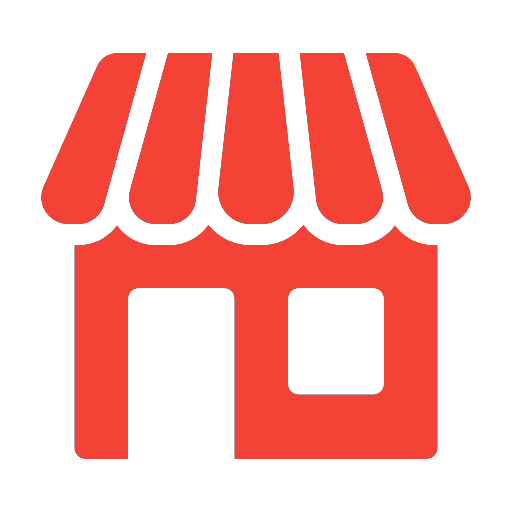
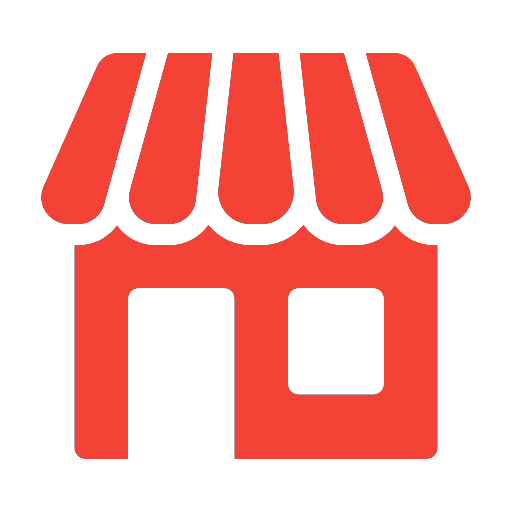
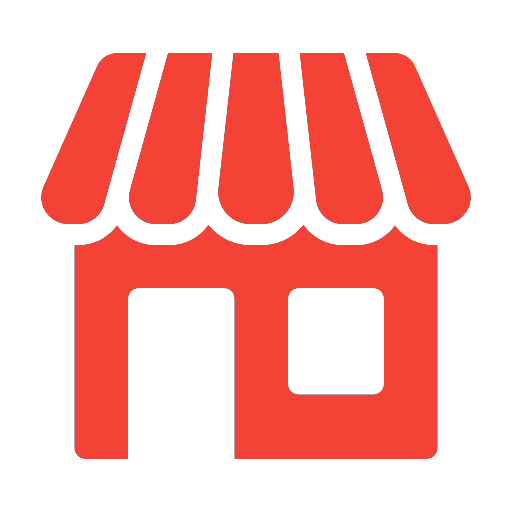
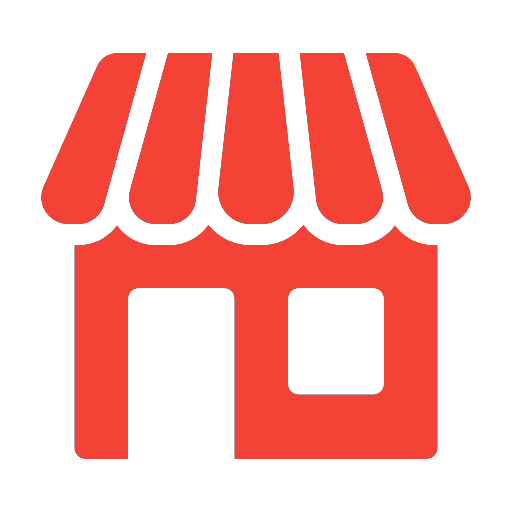
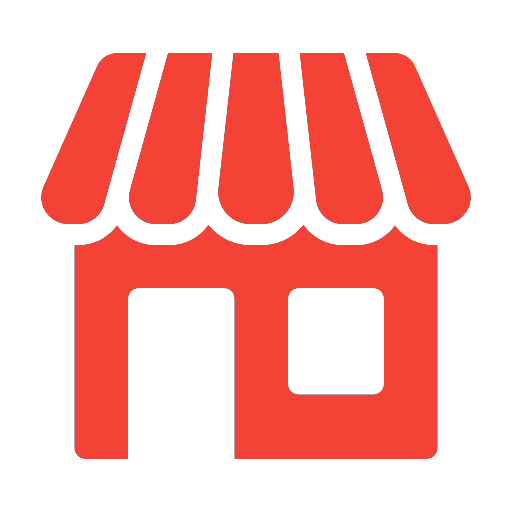
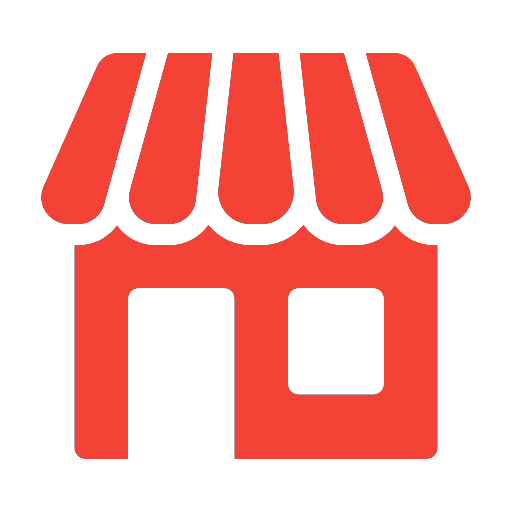
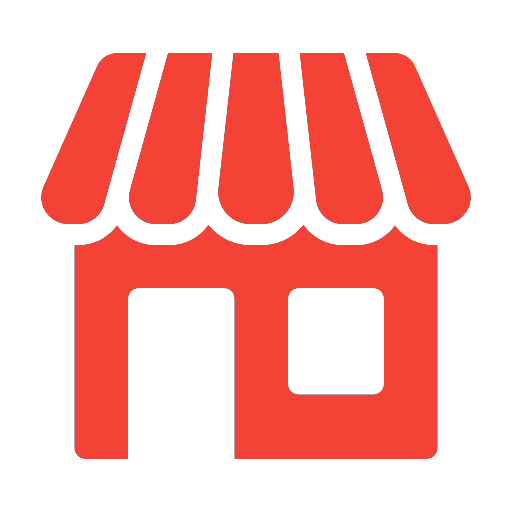
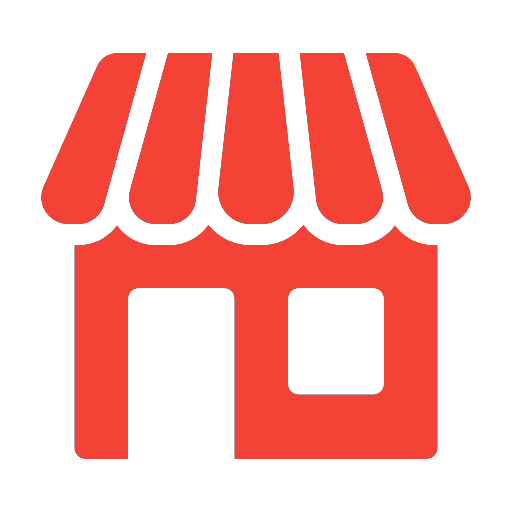
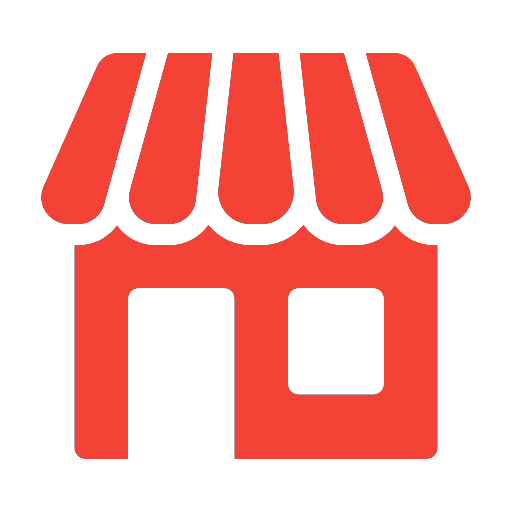
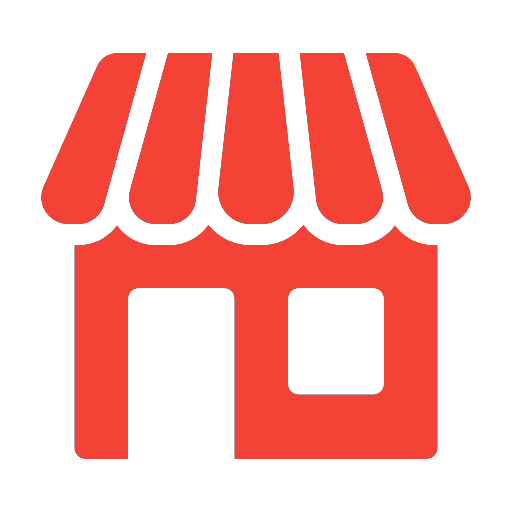
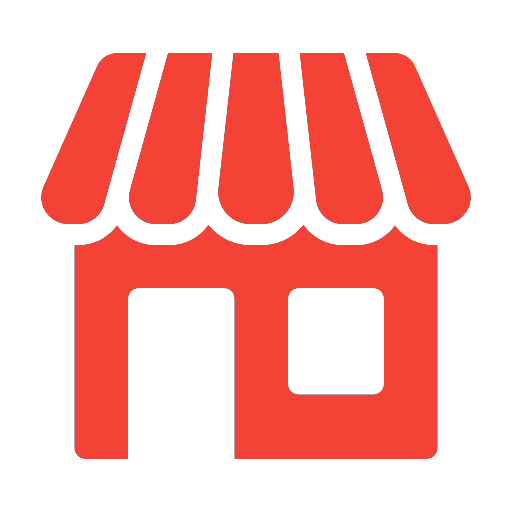
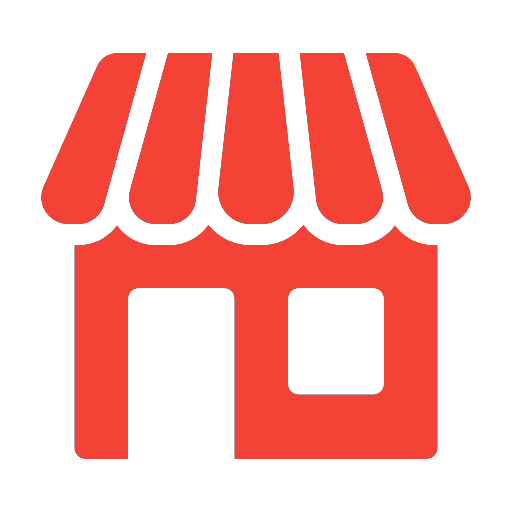
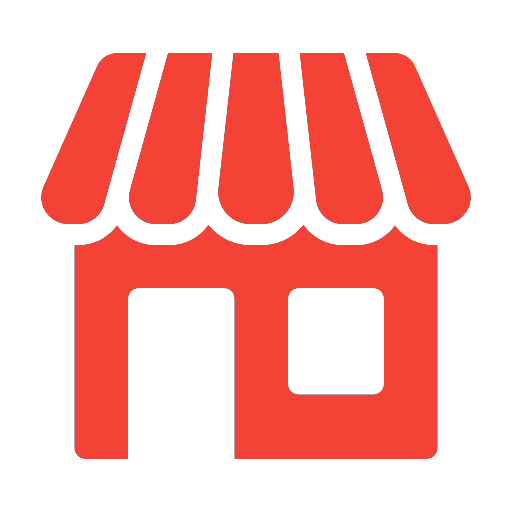
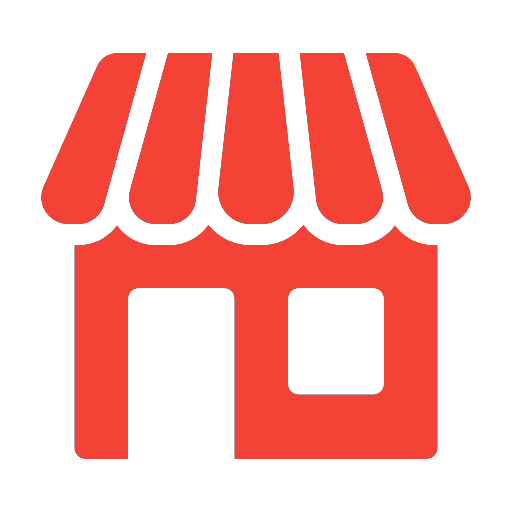
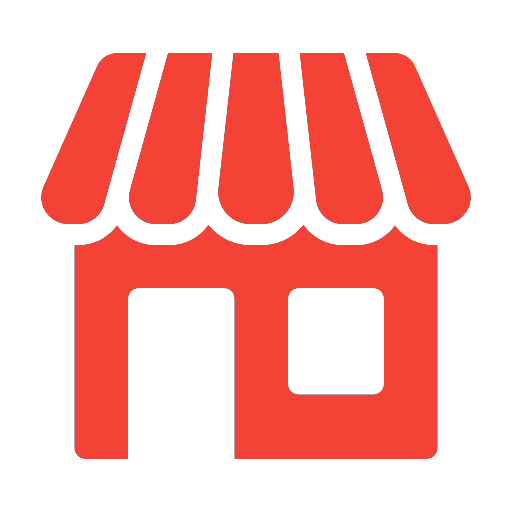
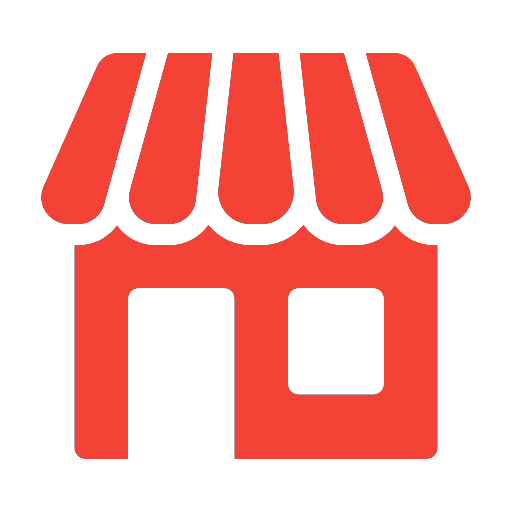
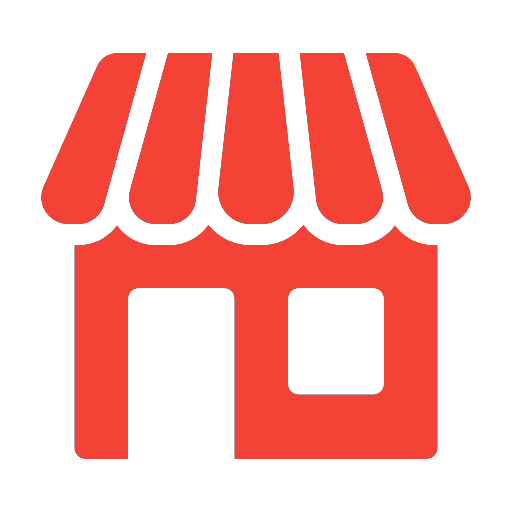
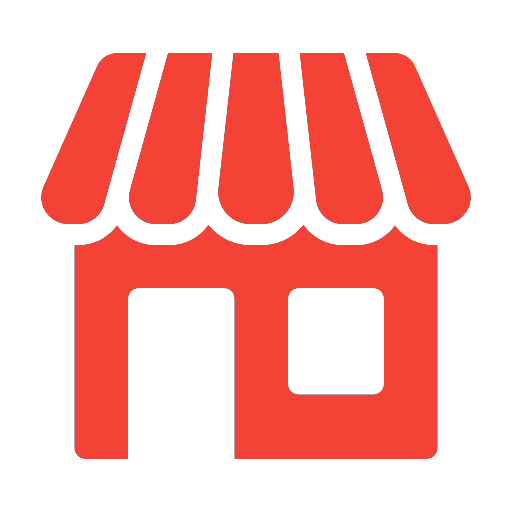
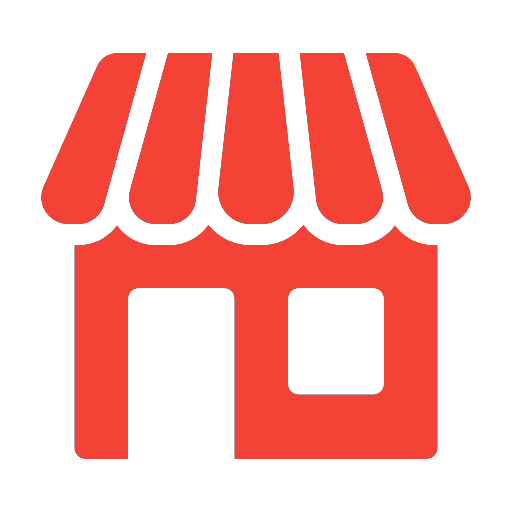
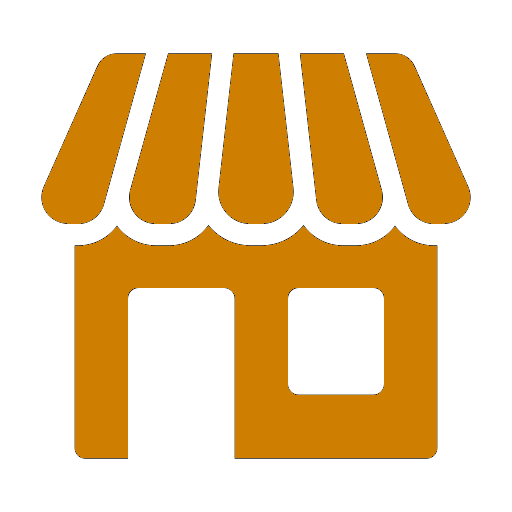
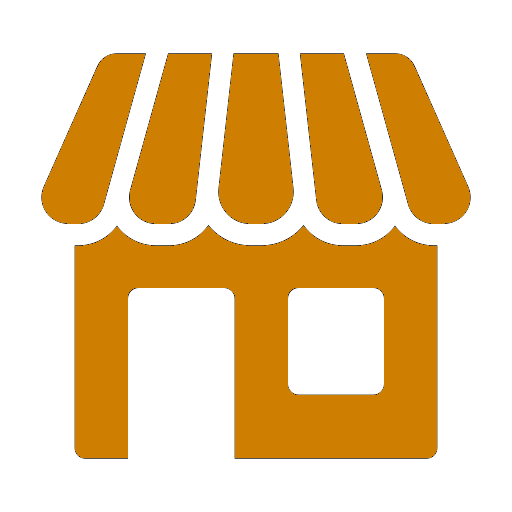
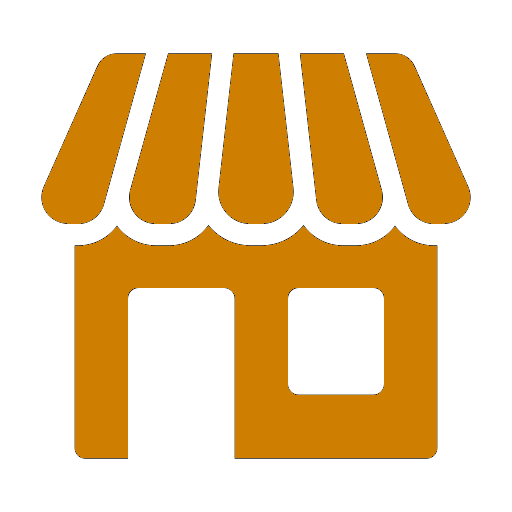
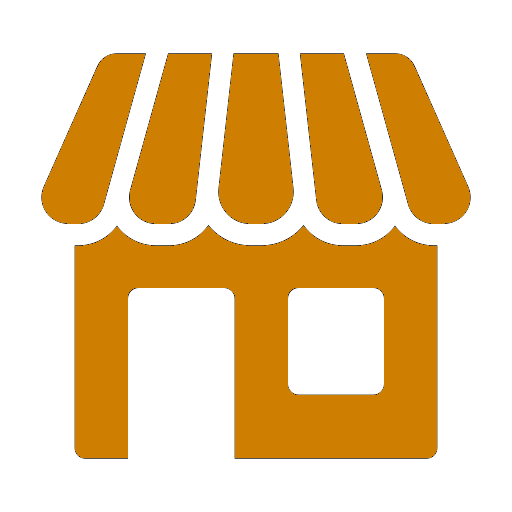
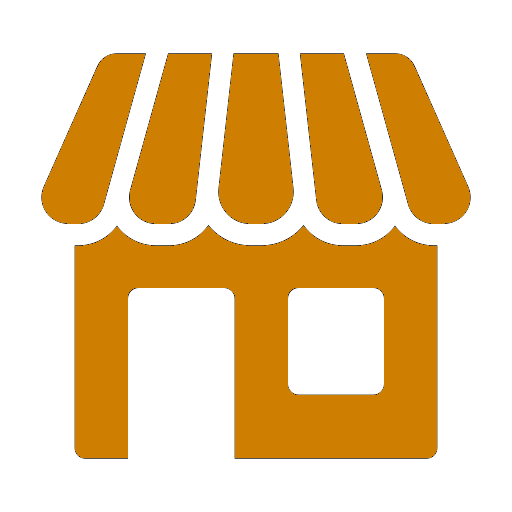
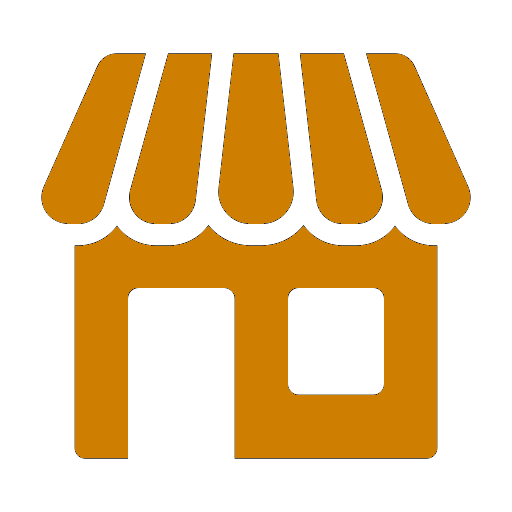
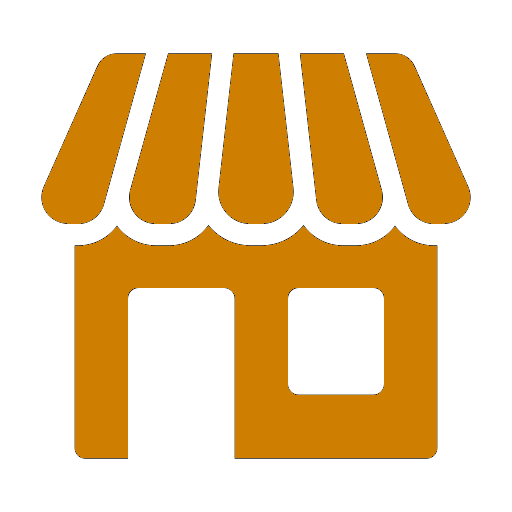
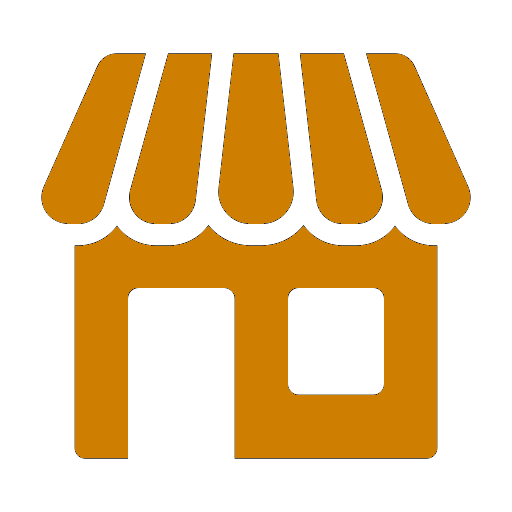
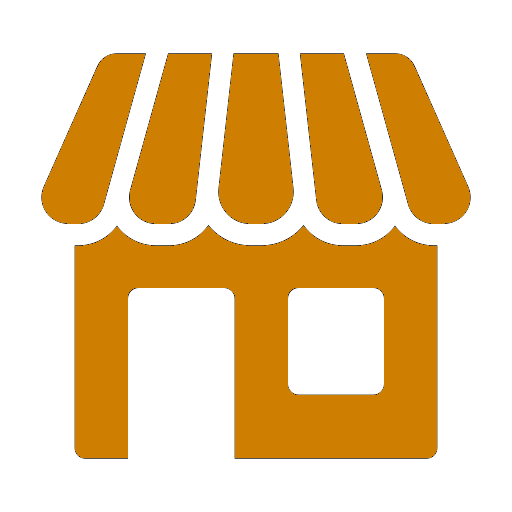
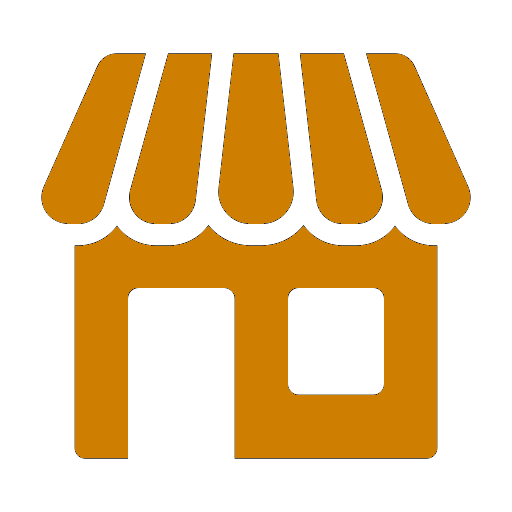
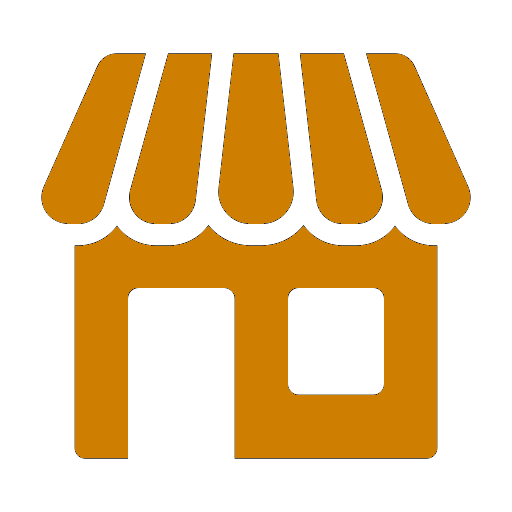
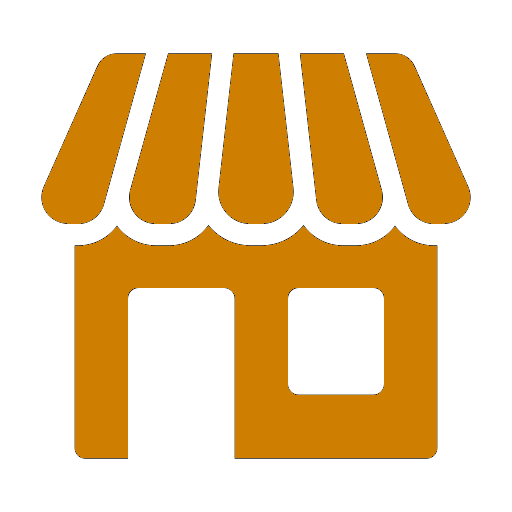
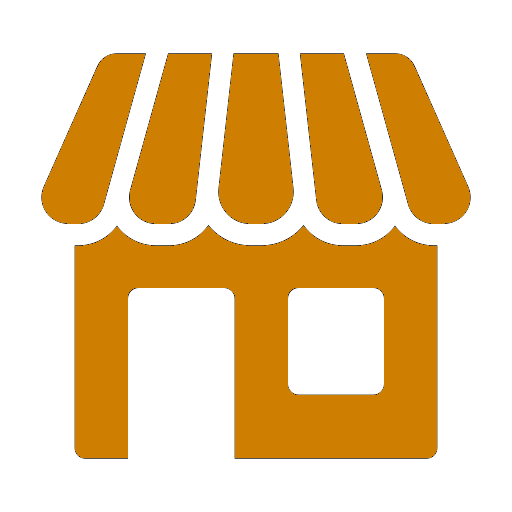
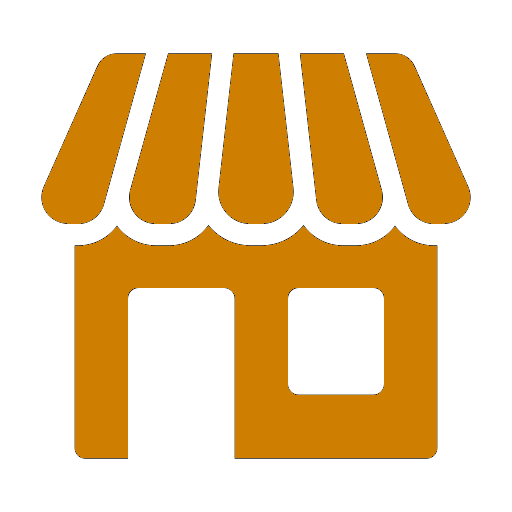
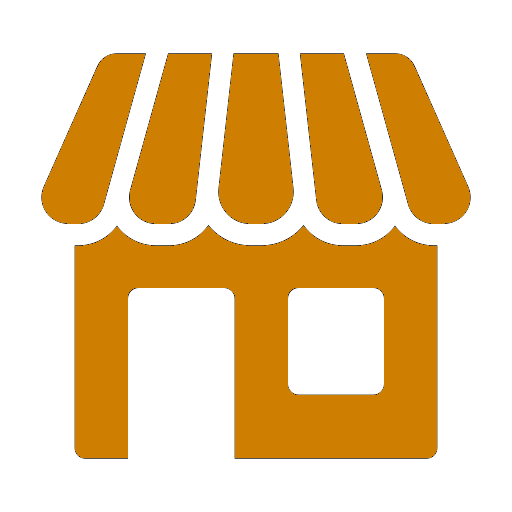
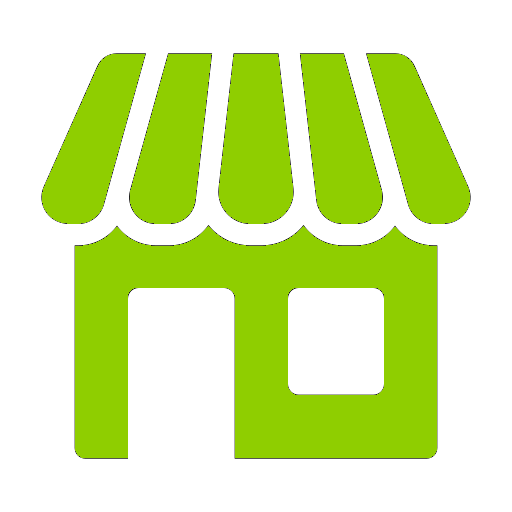
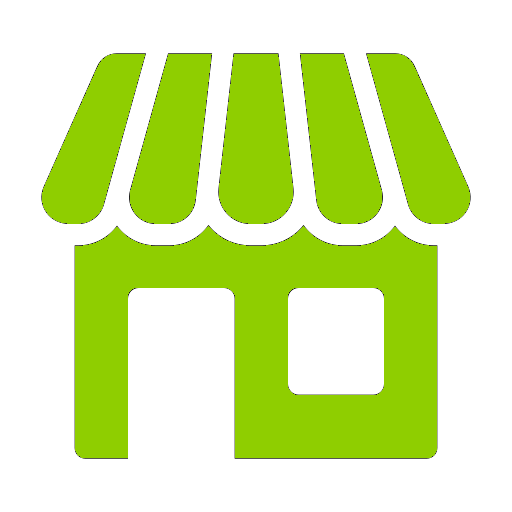
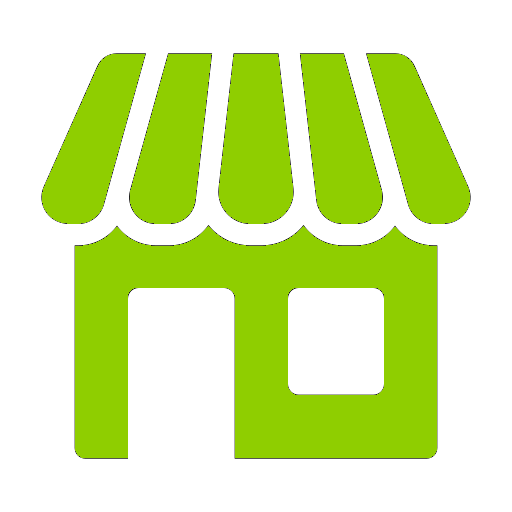
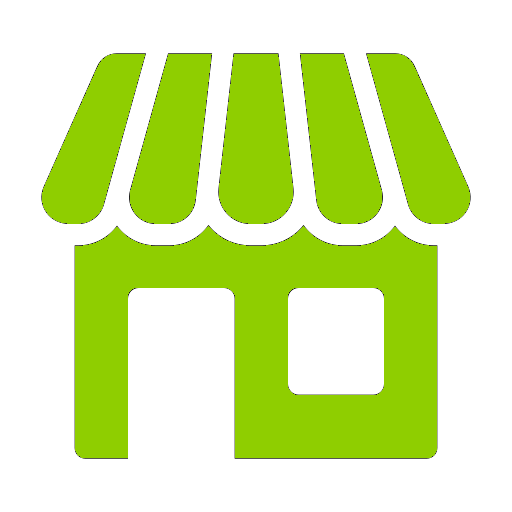
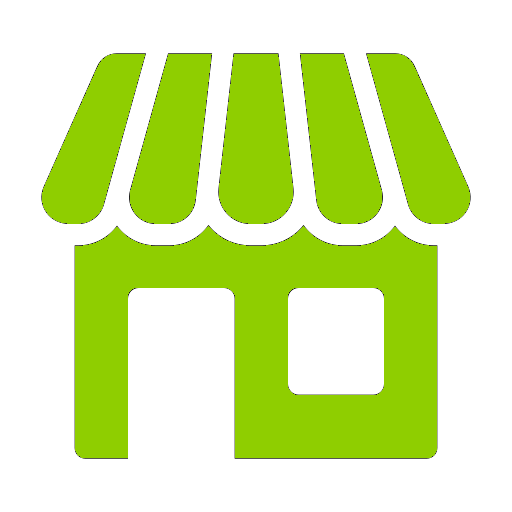
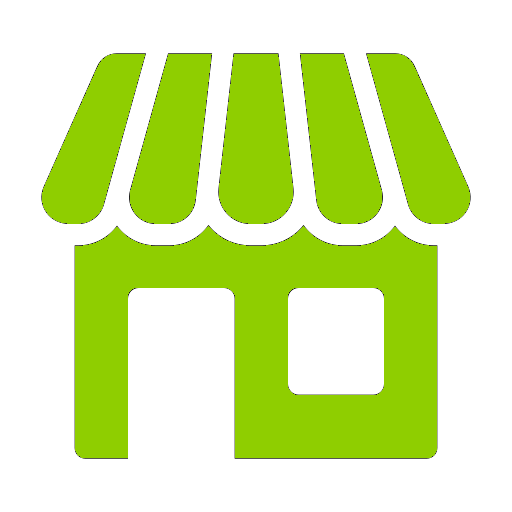
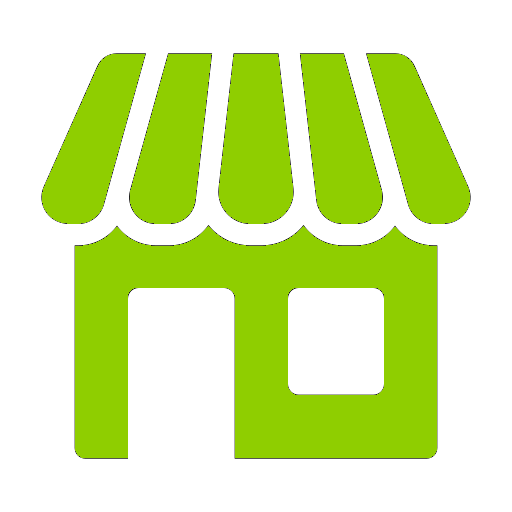
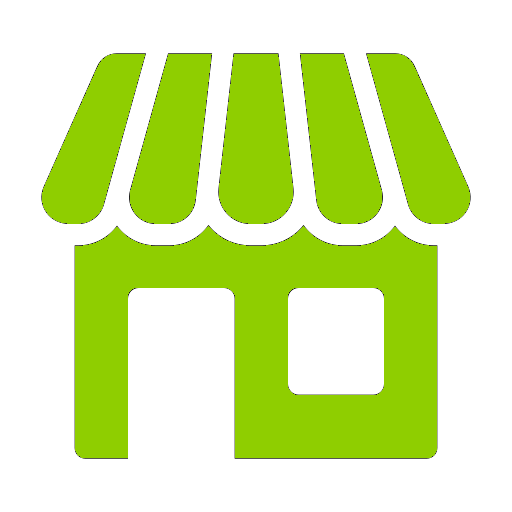
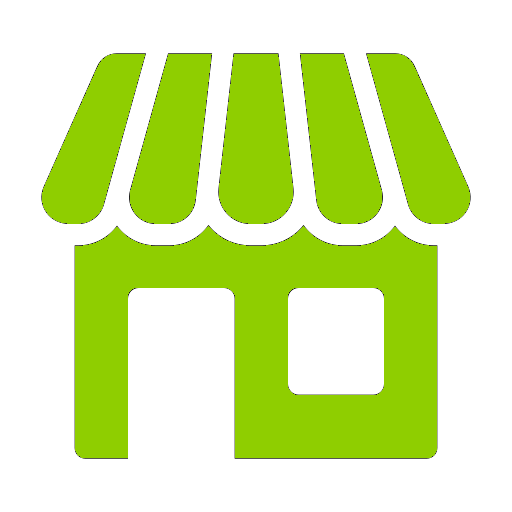
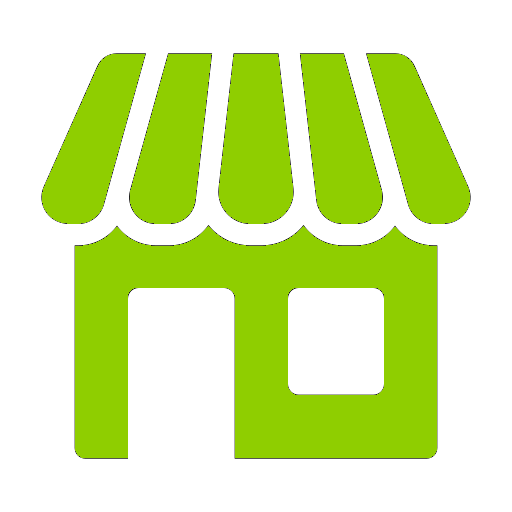
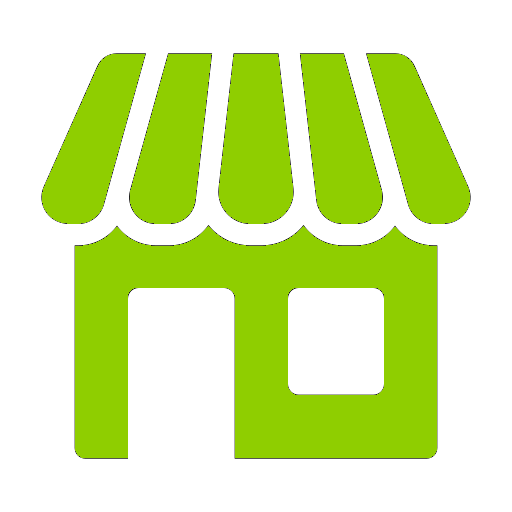
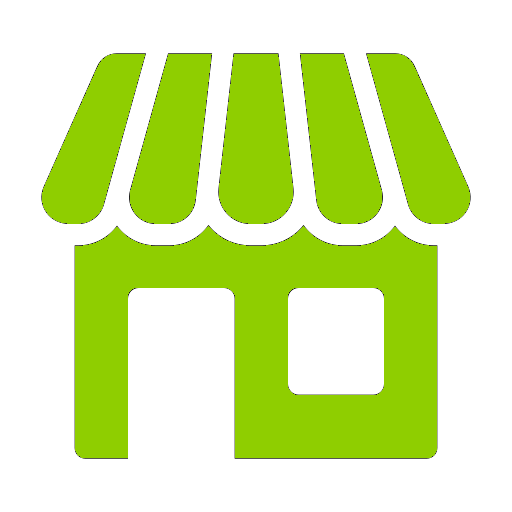
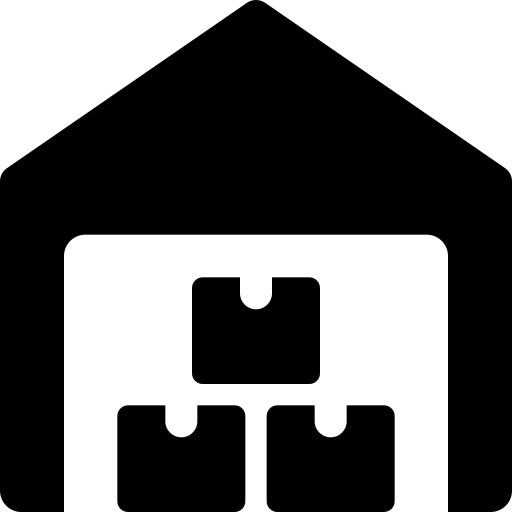

In [12]:
# plot map of Saturday routes coloured by demand
saturday_map_demand = initialise_map(locations)
plot_routes(locations, selected_saturday, saturday_map_demand, col="Demand", min=min_demand, max=max_demand)


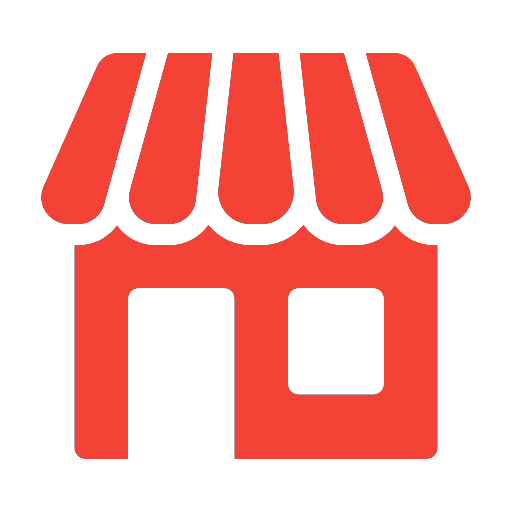
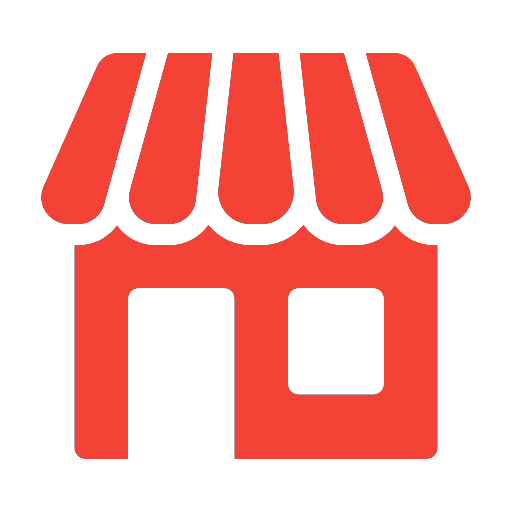
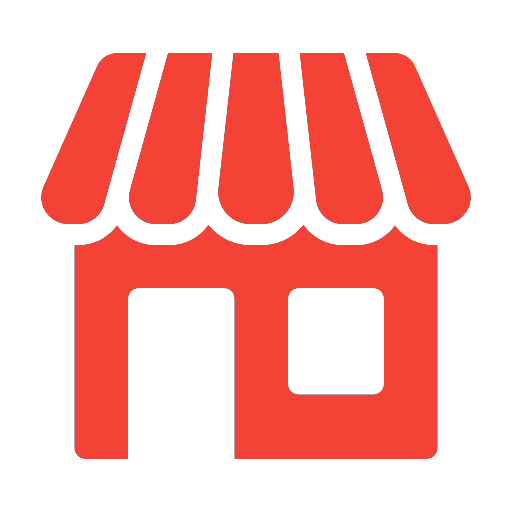
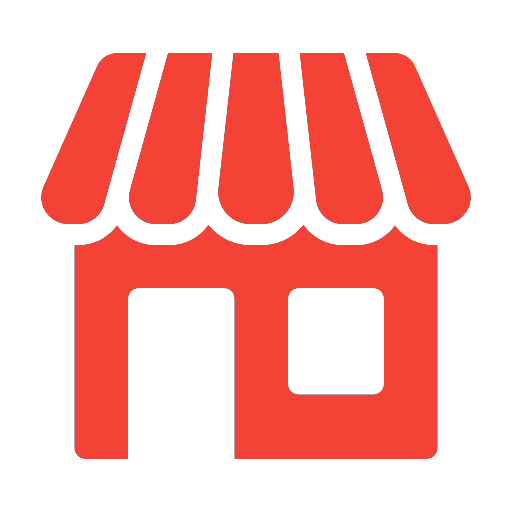
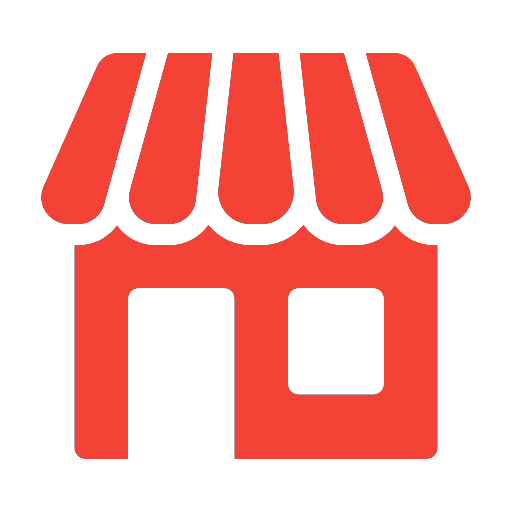
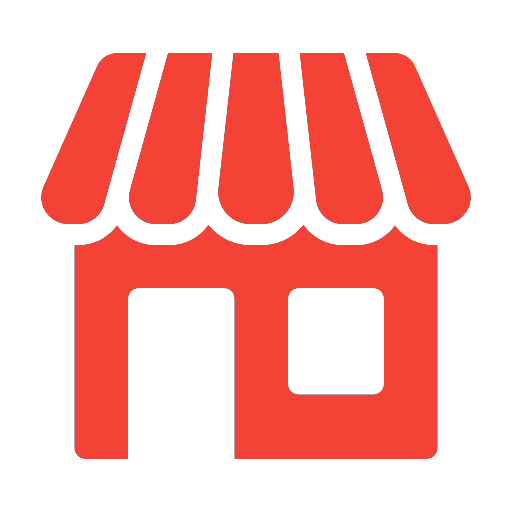
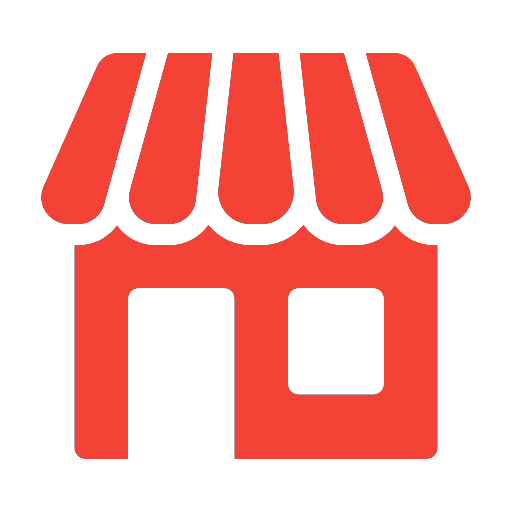
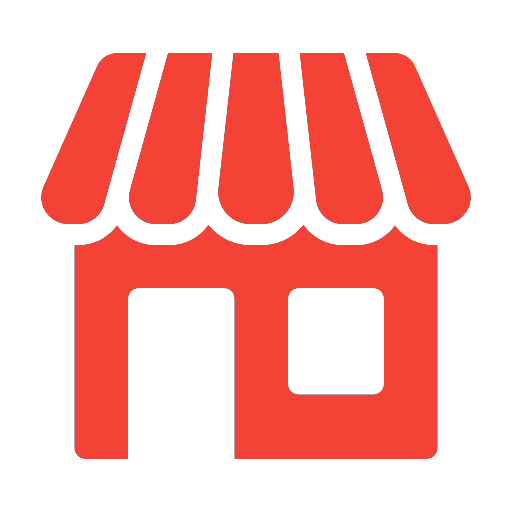
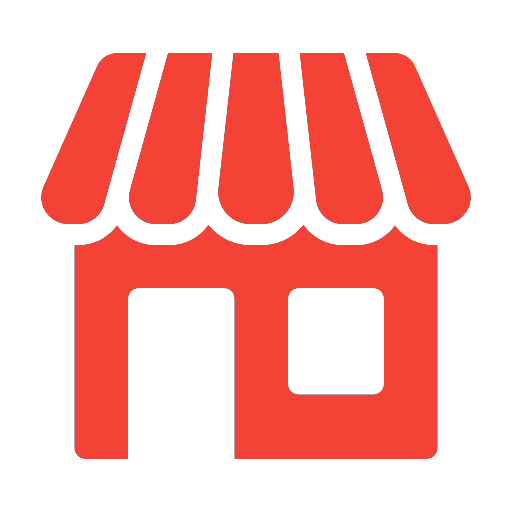
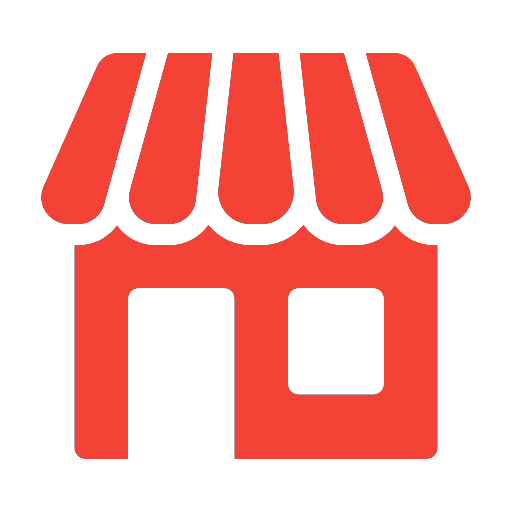
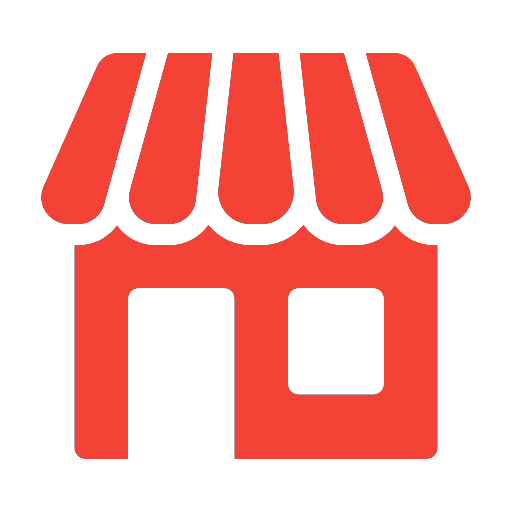
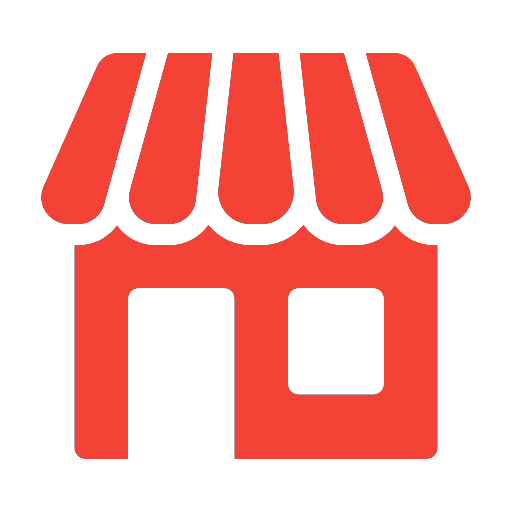
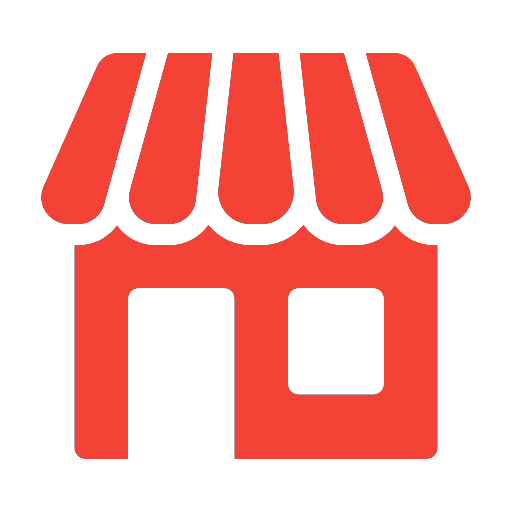
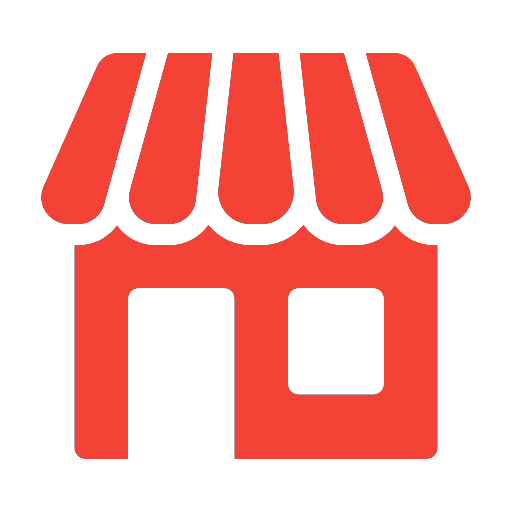
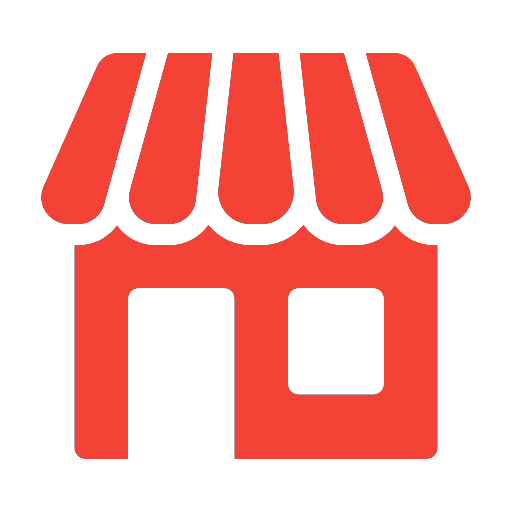
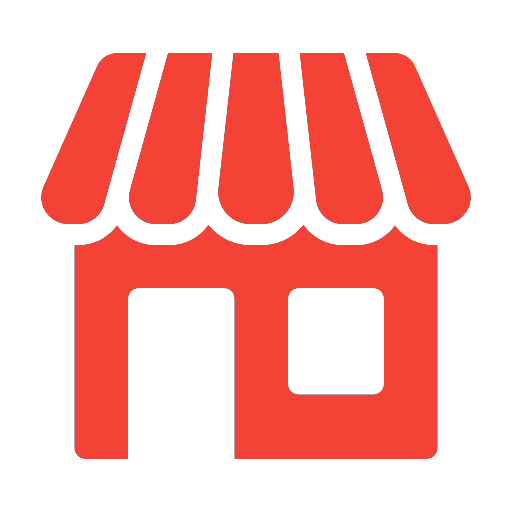
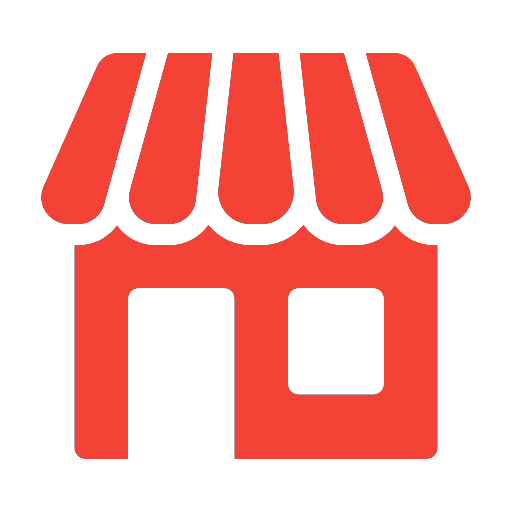
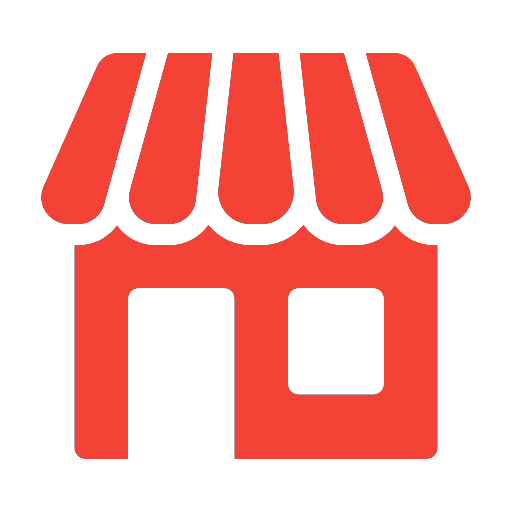
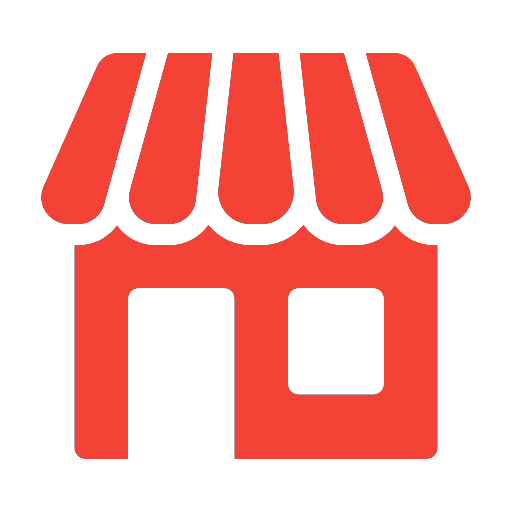
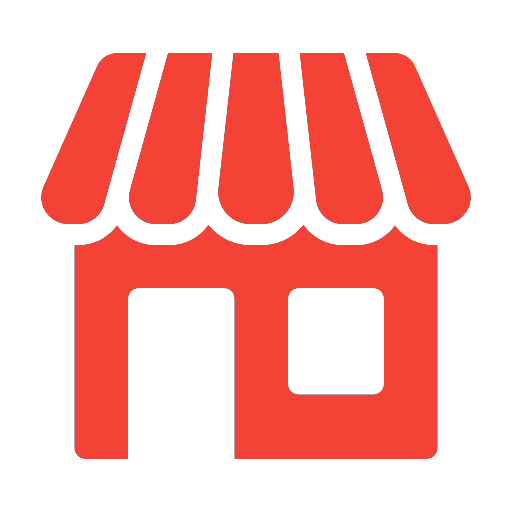
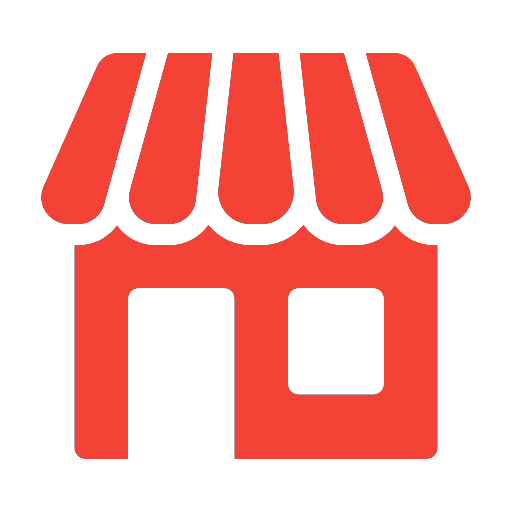
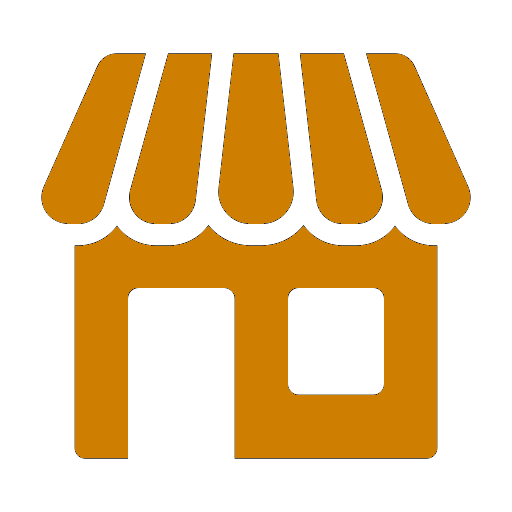
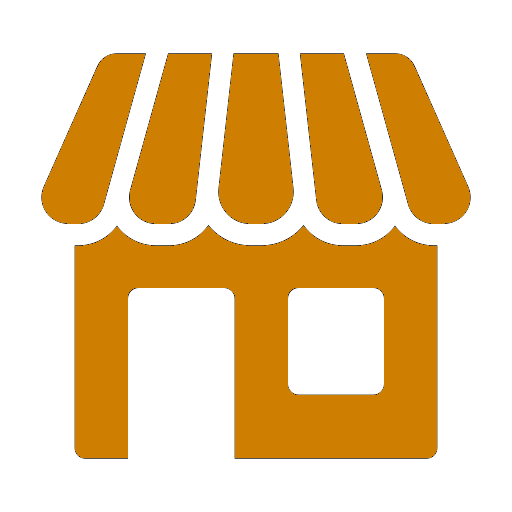
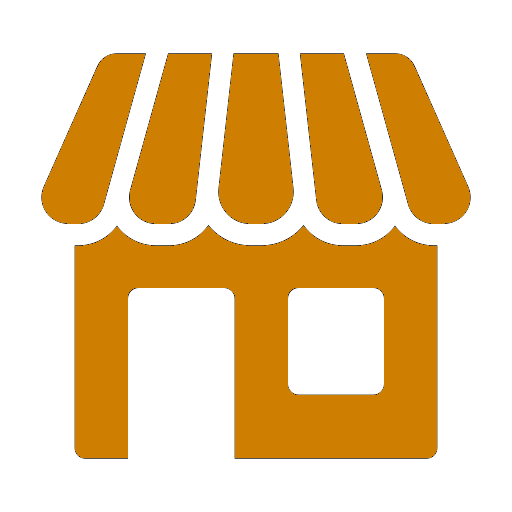
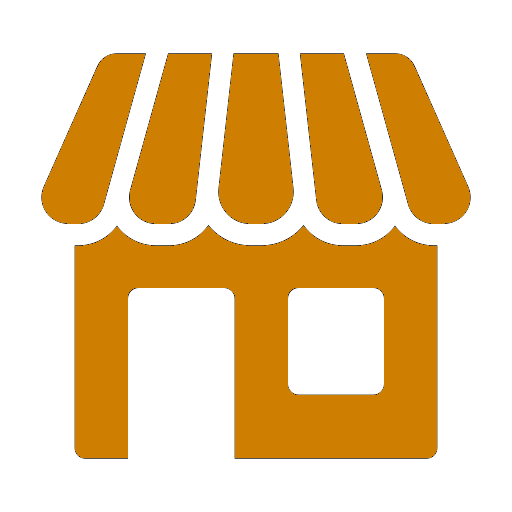
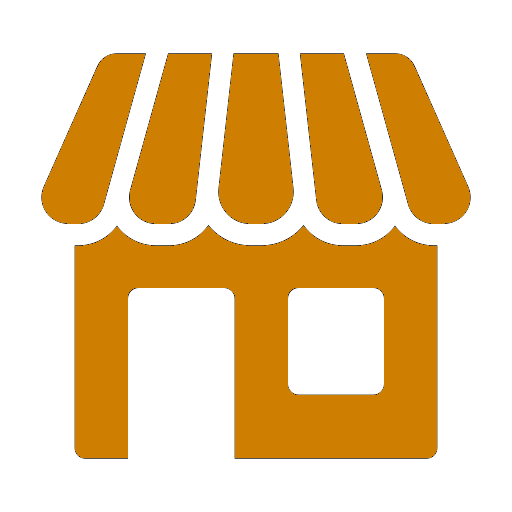
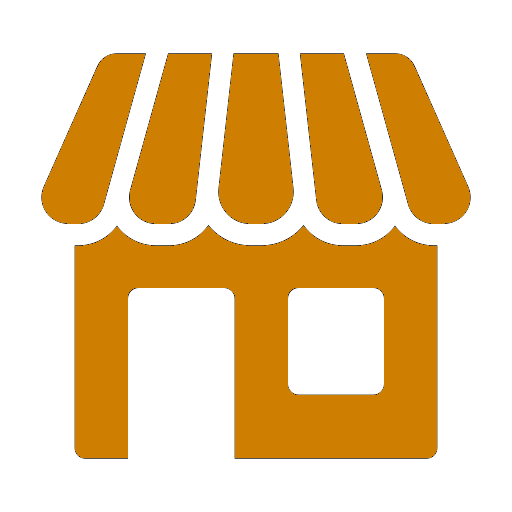
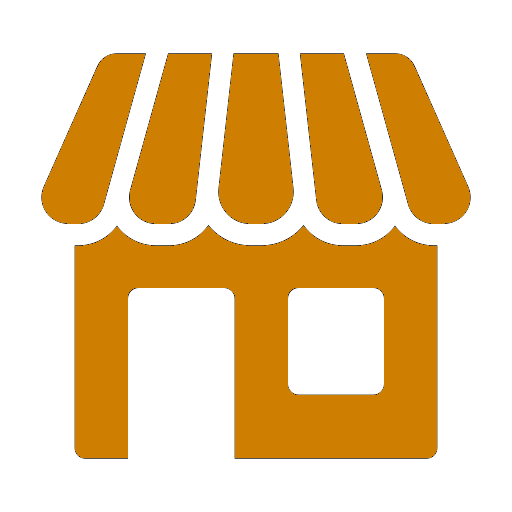
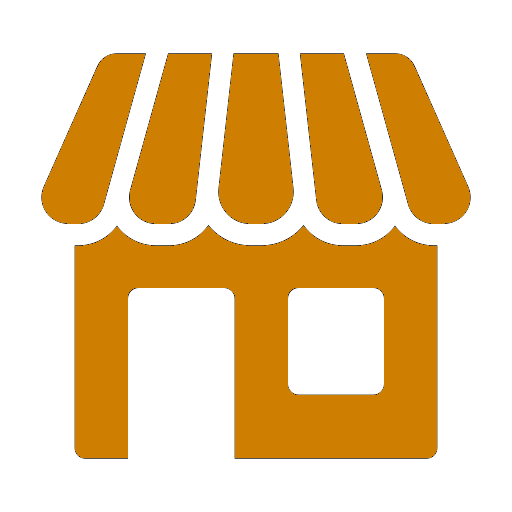
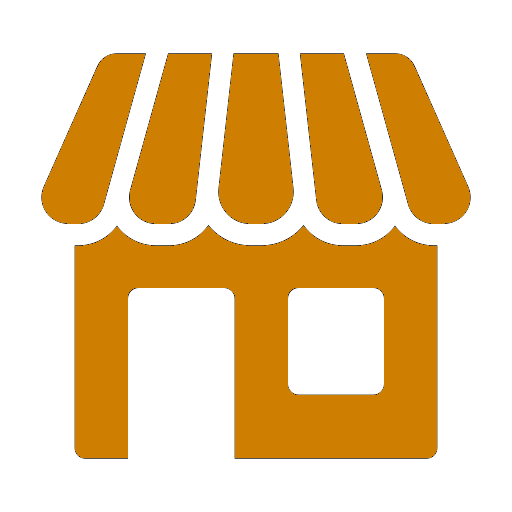
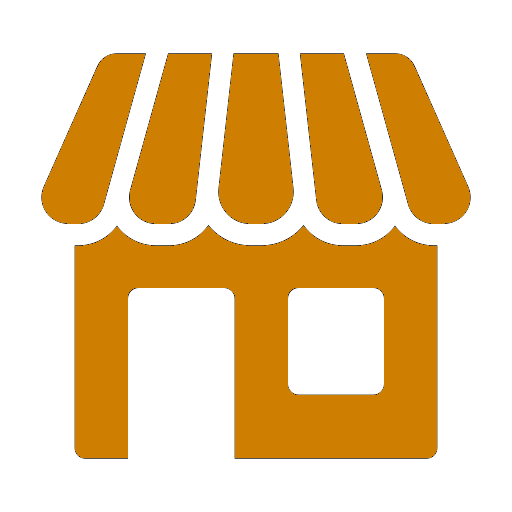
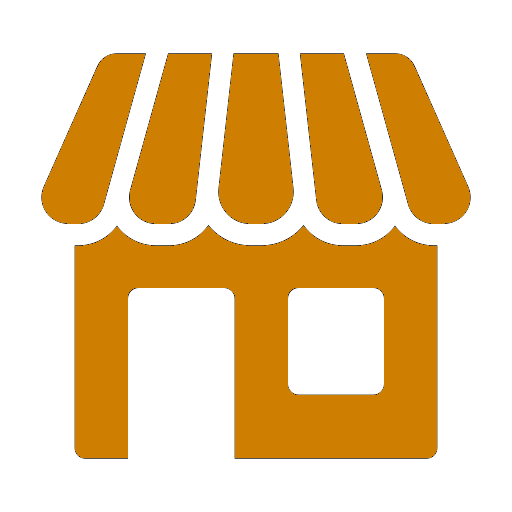
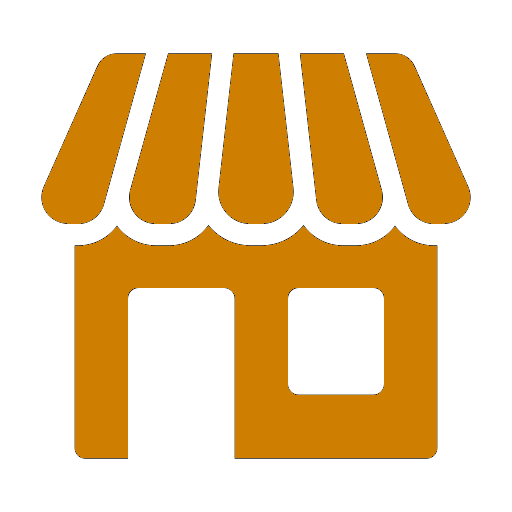
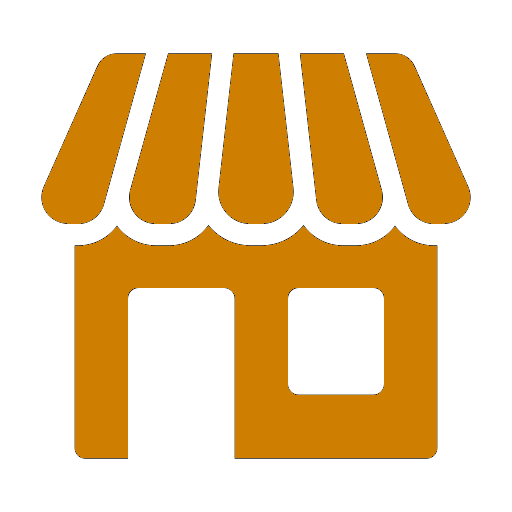
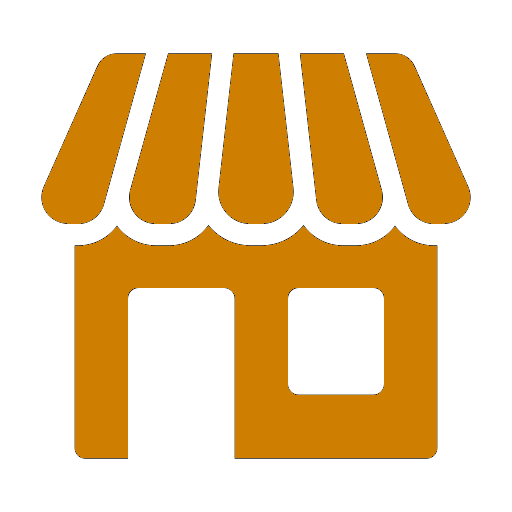
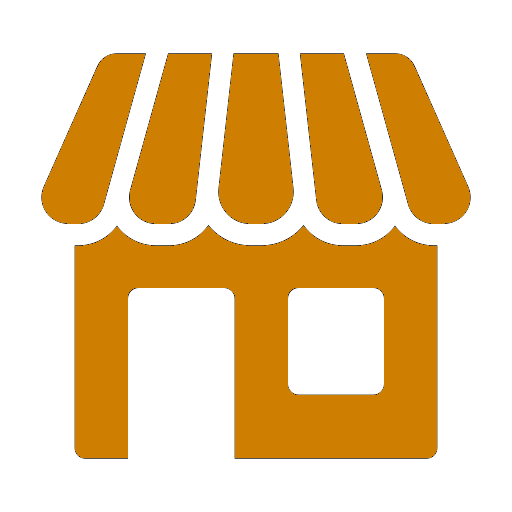
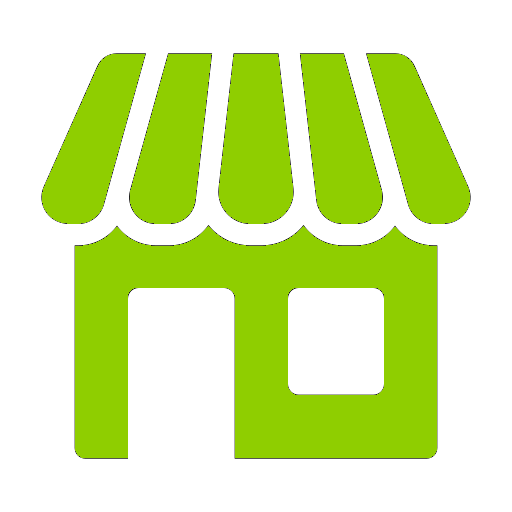
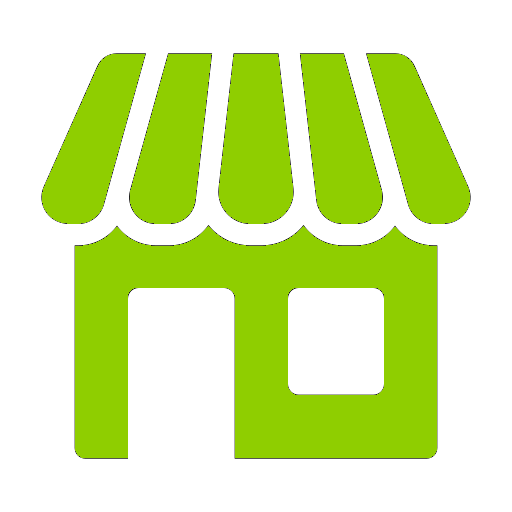
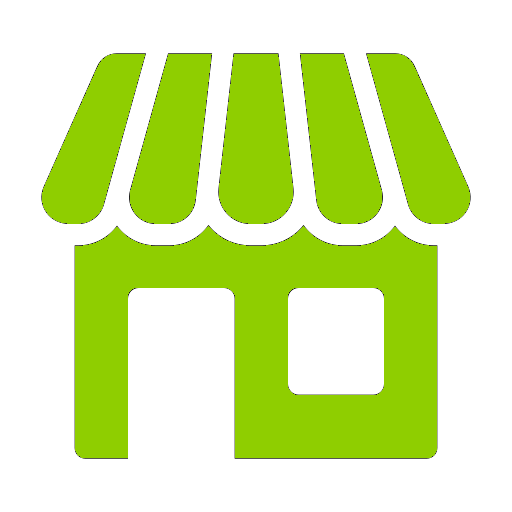
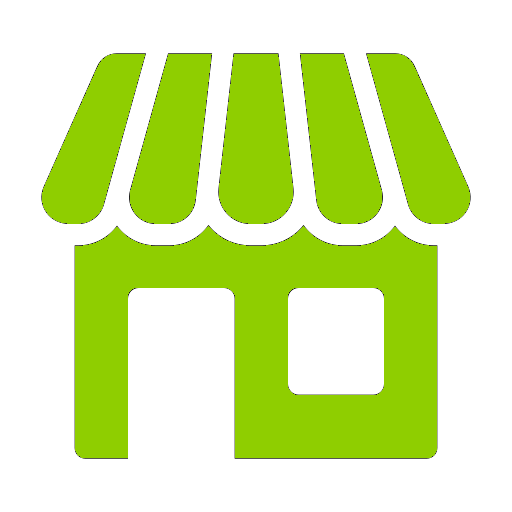
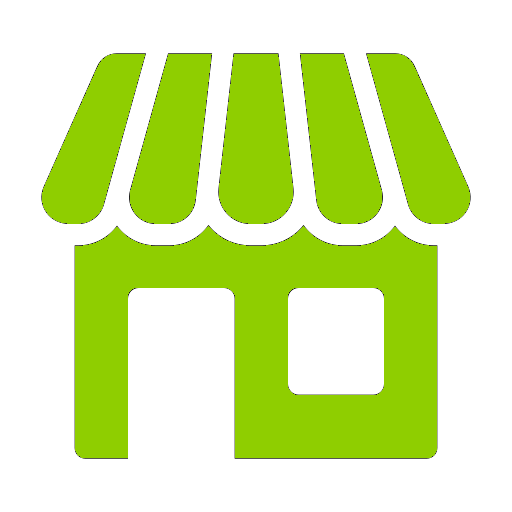
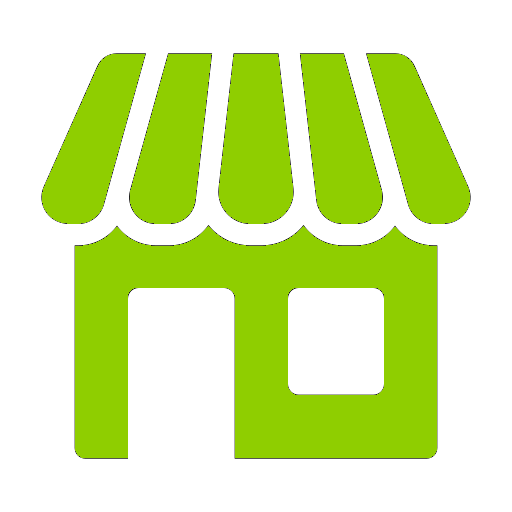
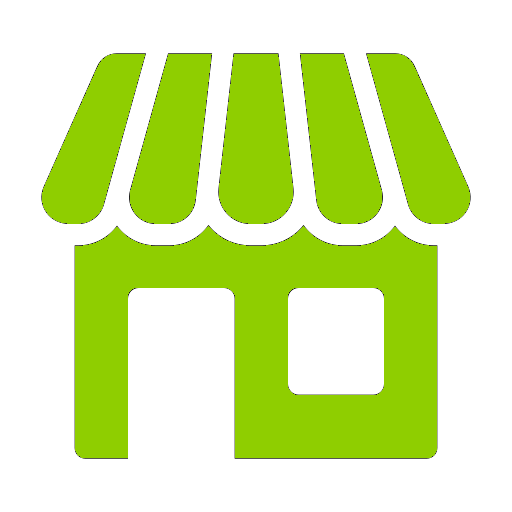
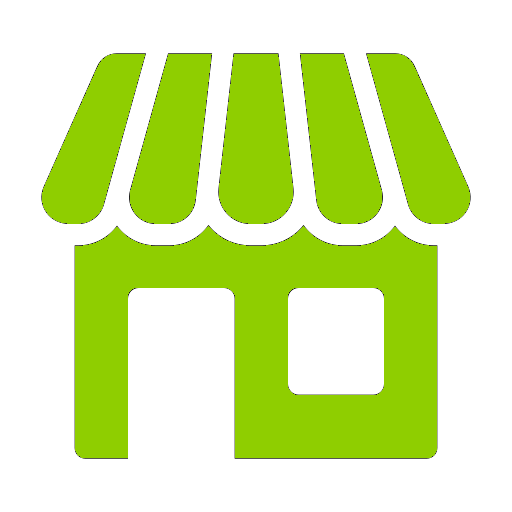
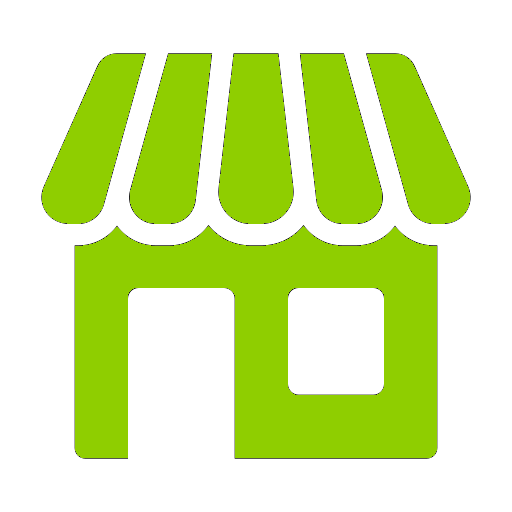
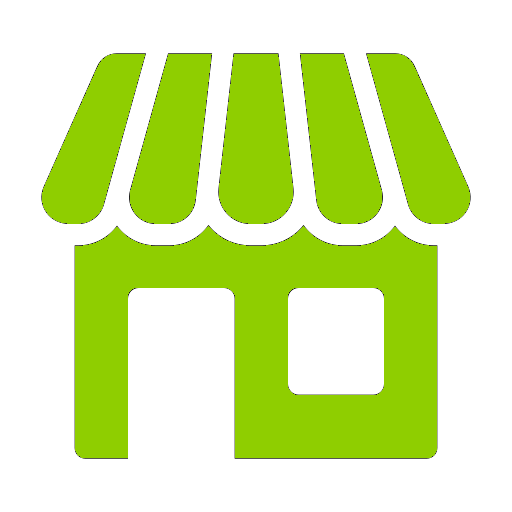
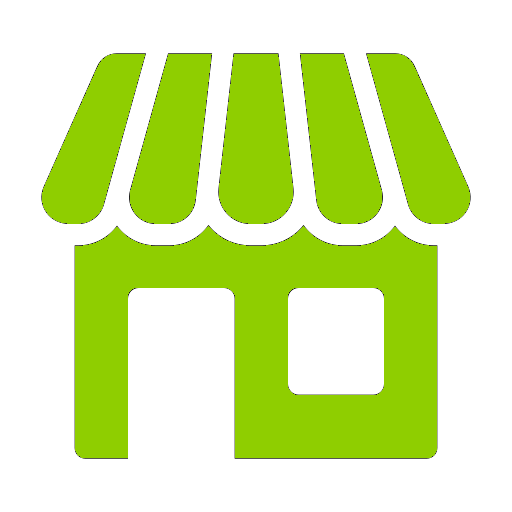
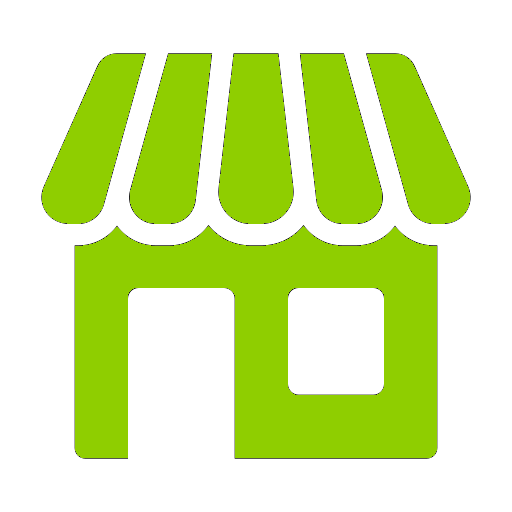
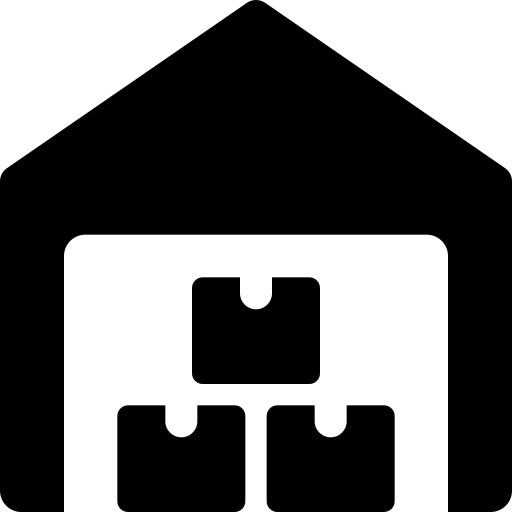

In [15]:
# plot map of weekday routes coloured by route costs
weekday_map_costs = initialise_map(locations)
plot_routes(locations, selected_weekday, weekday_map_costs, min=min_cost, max=max_cost)


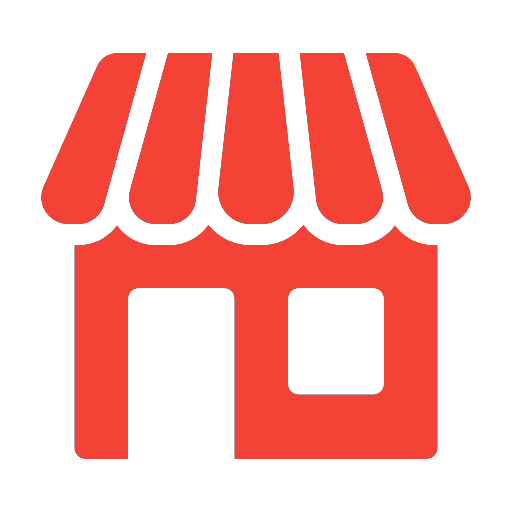
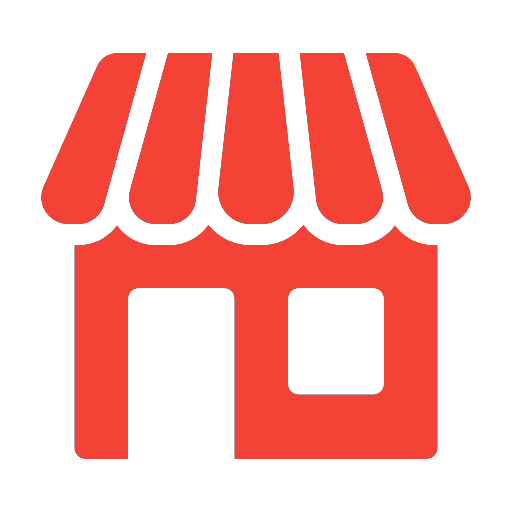
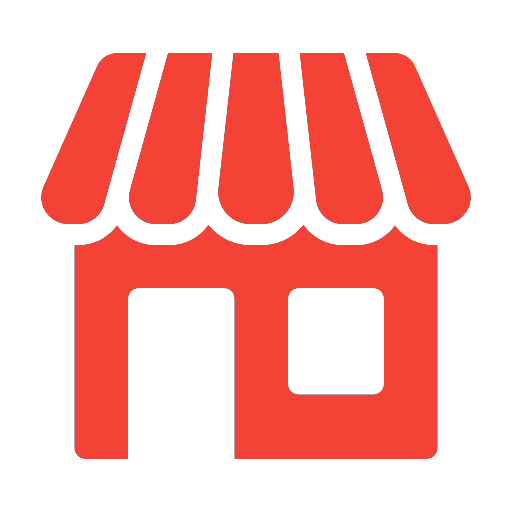
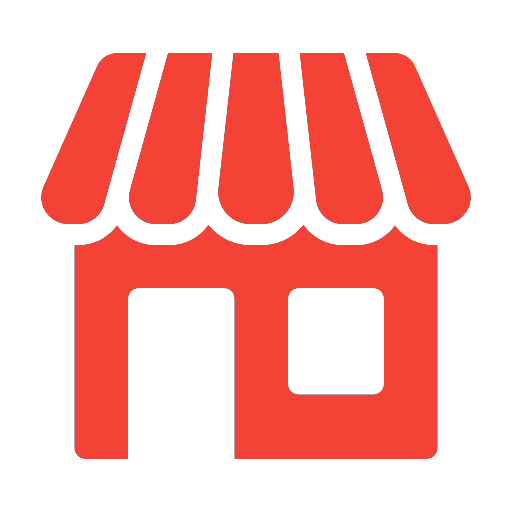
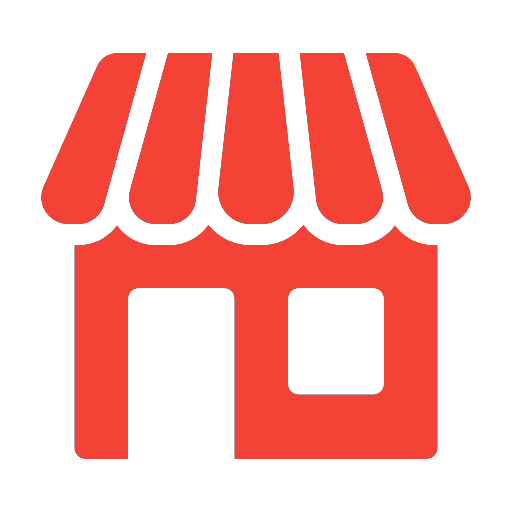
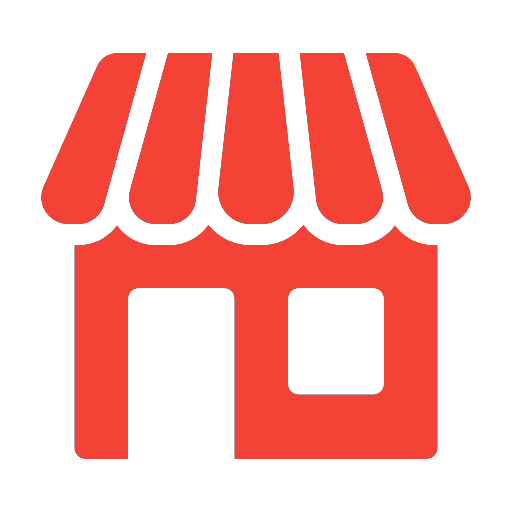
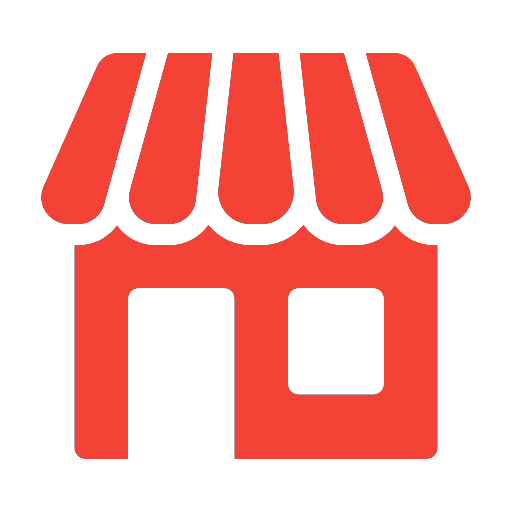
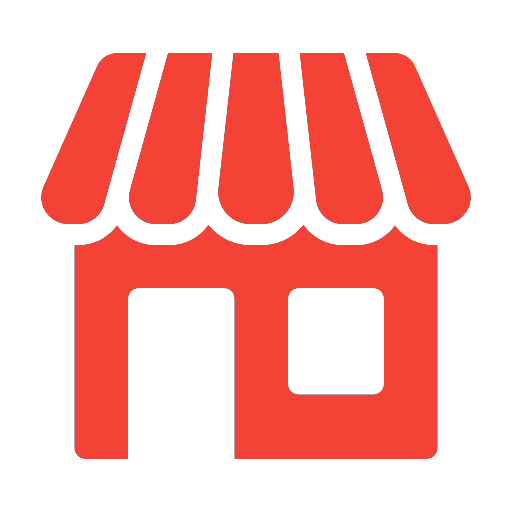
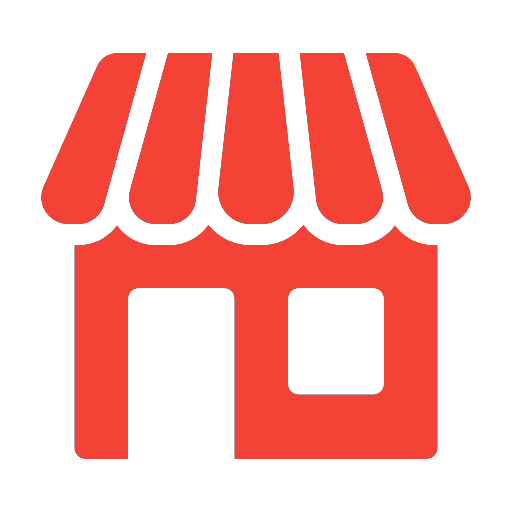
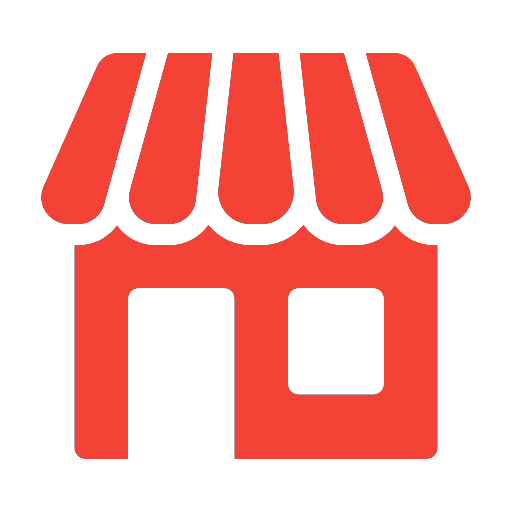
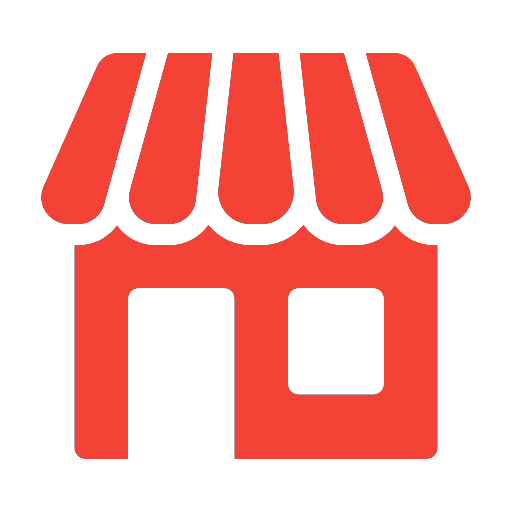
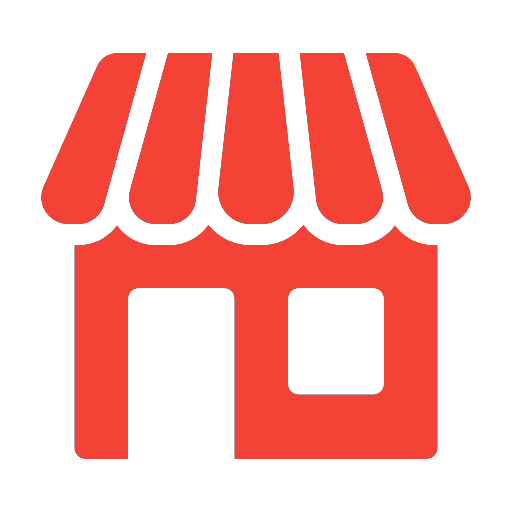
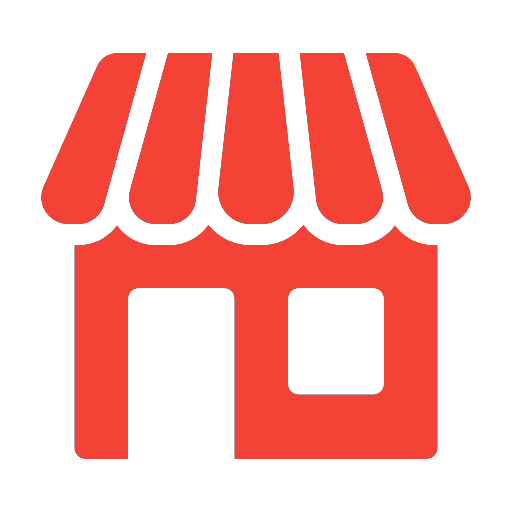
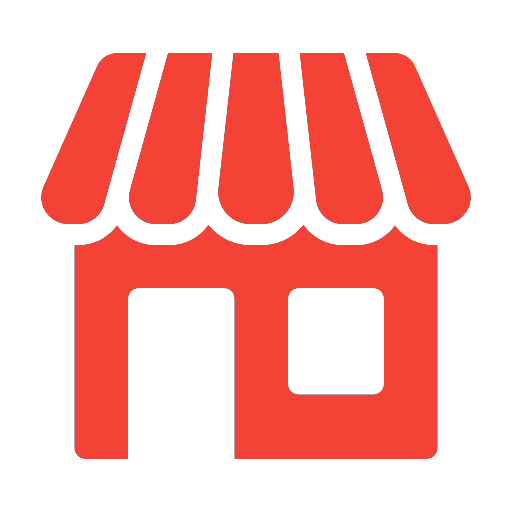
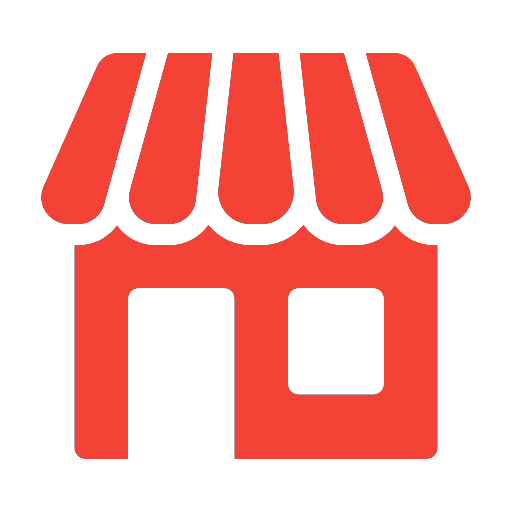
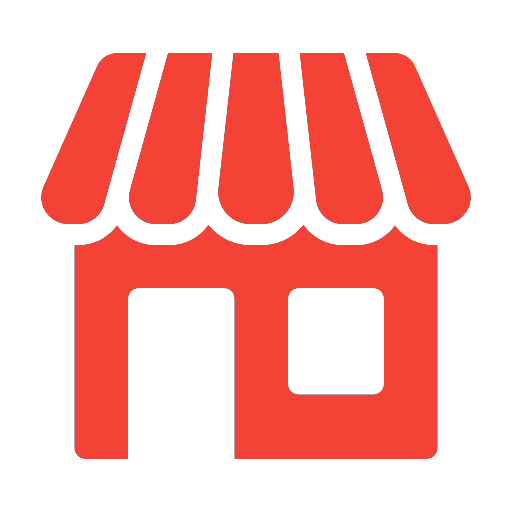
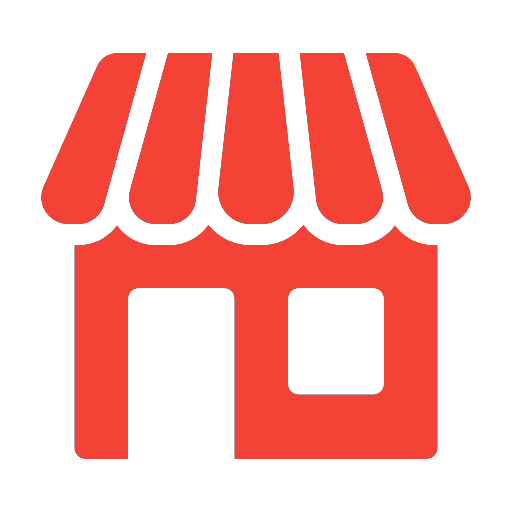
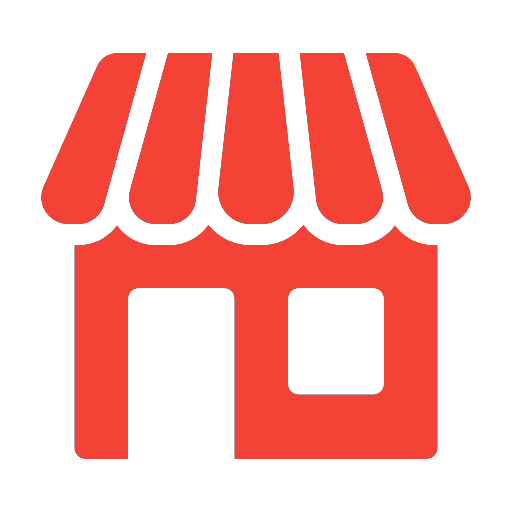
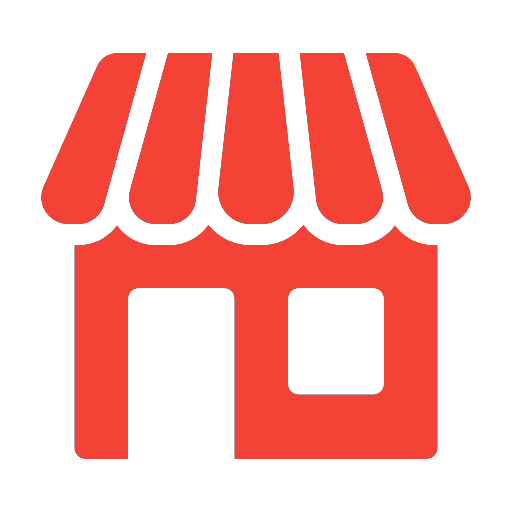
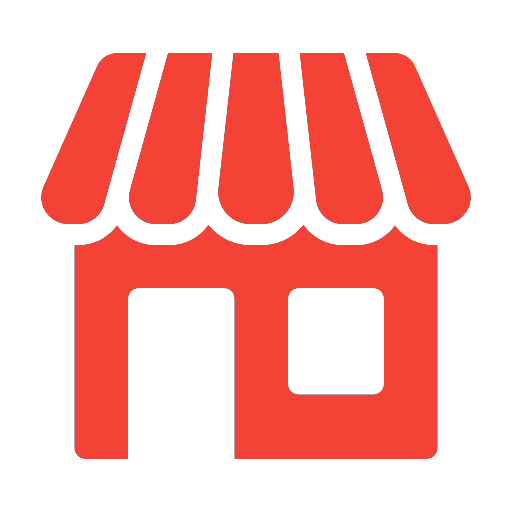
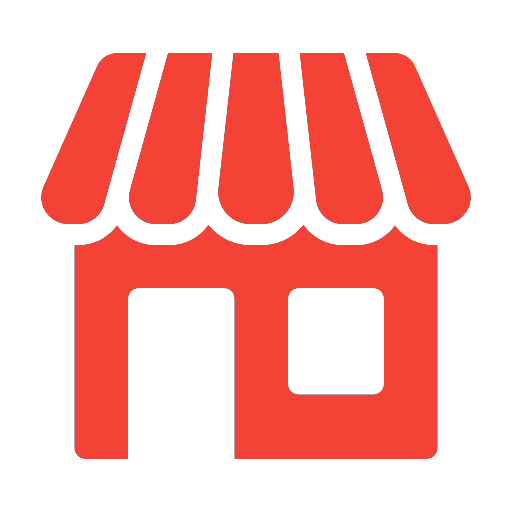
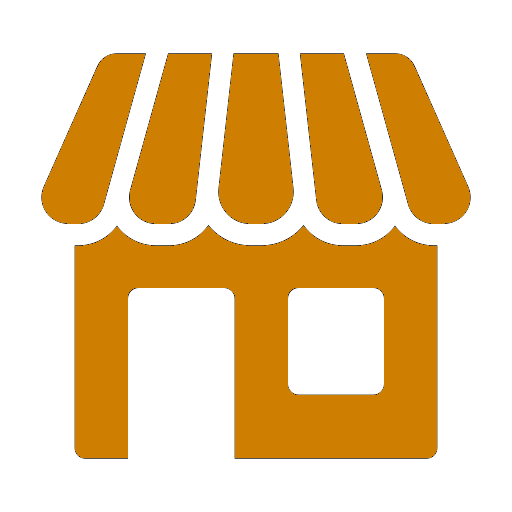
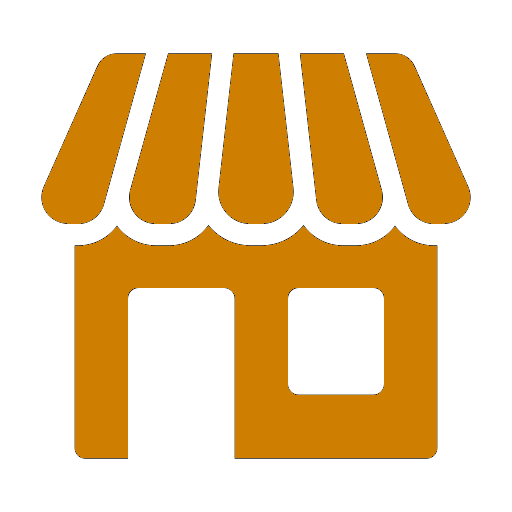
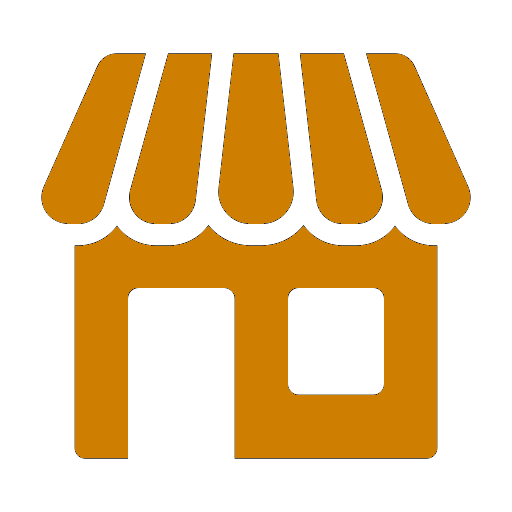
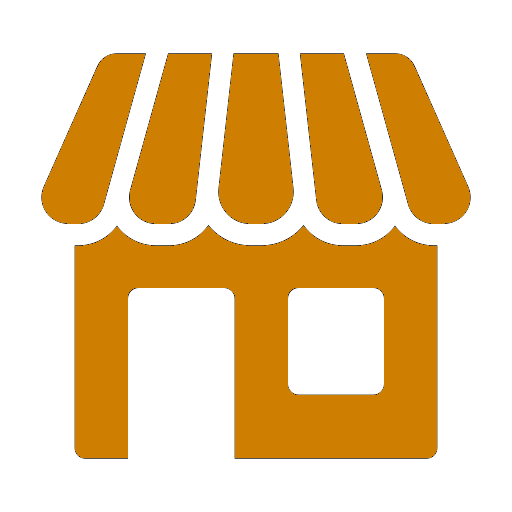
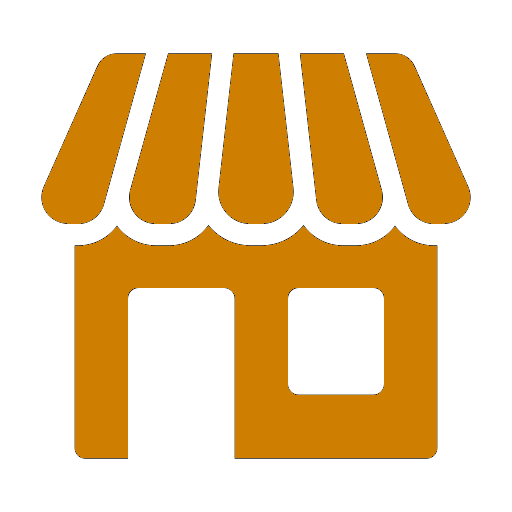
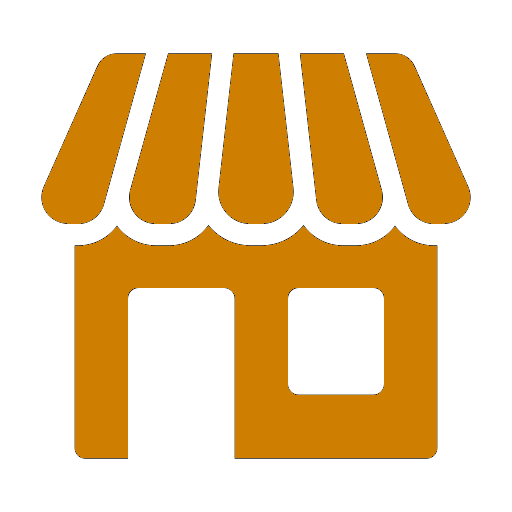
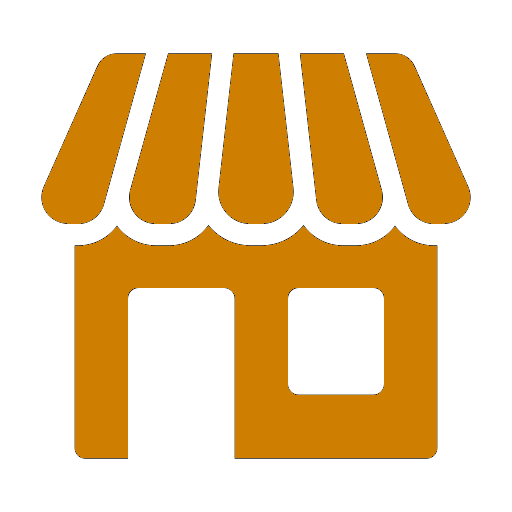
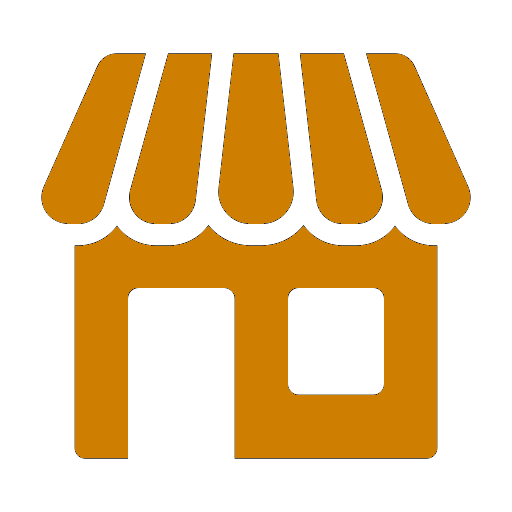
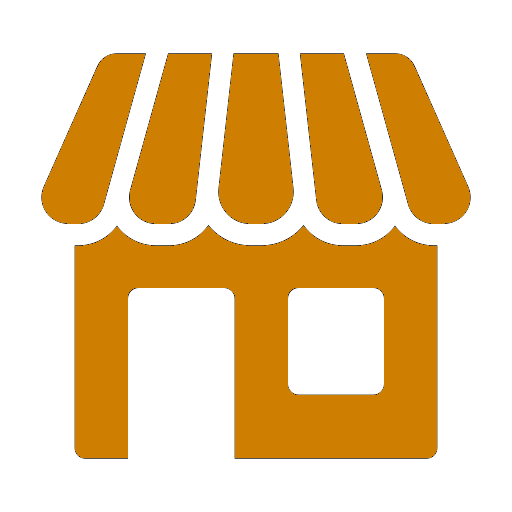
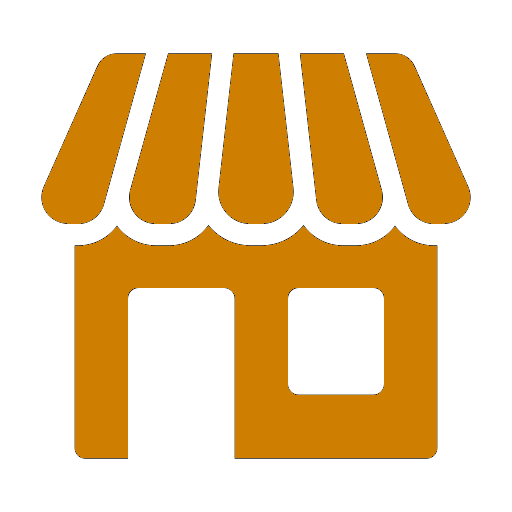
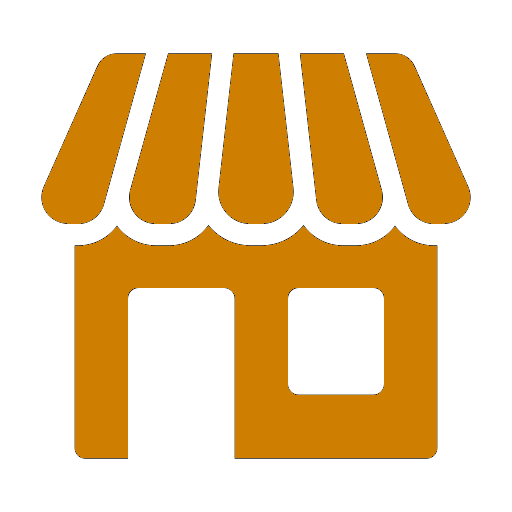
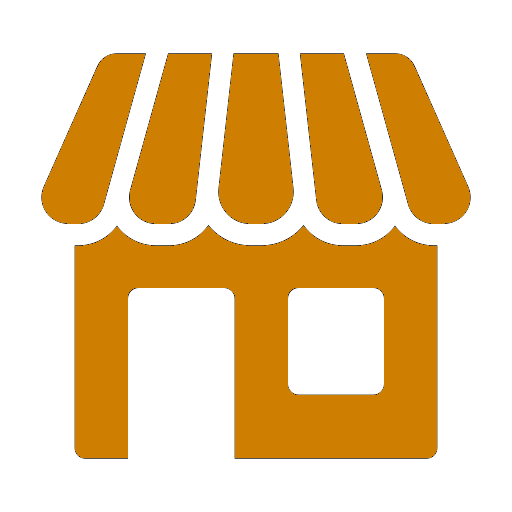
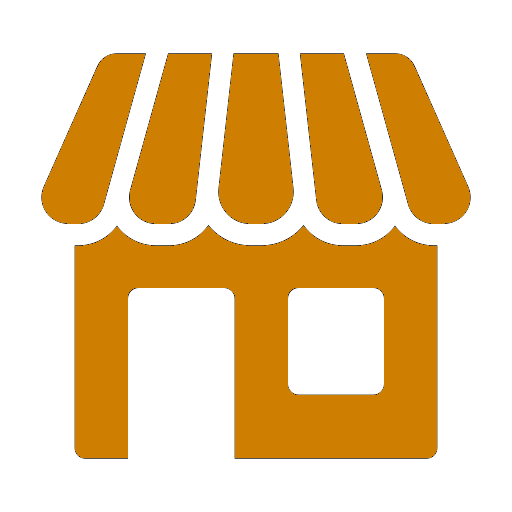
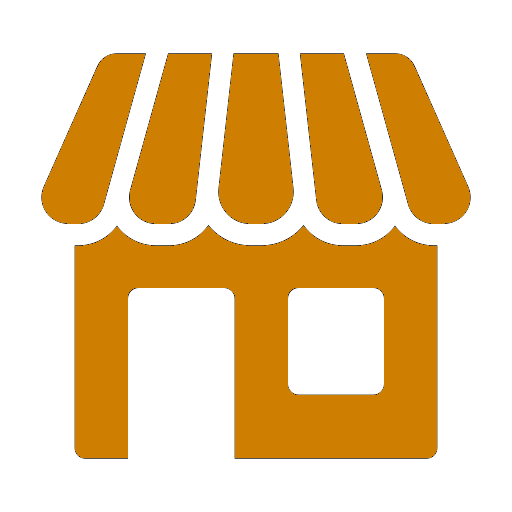
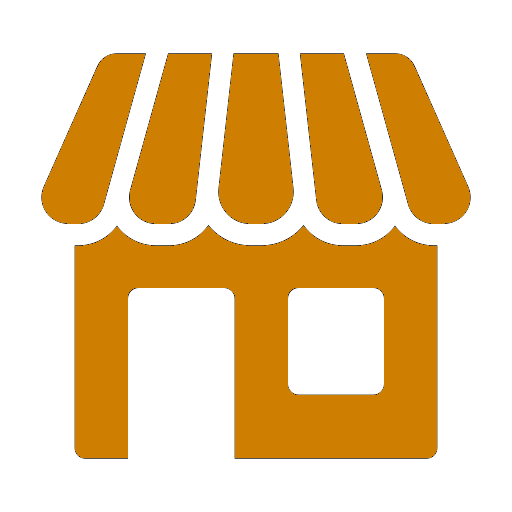
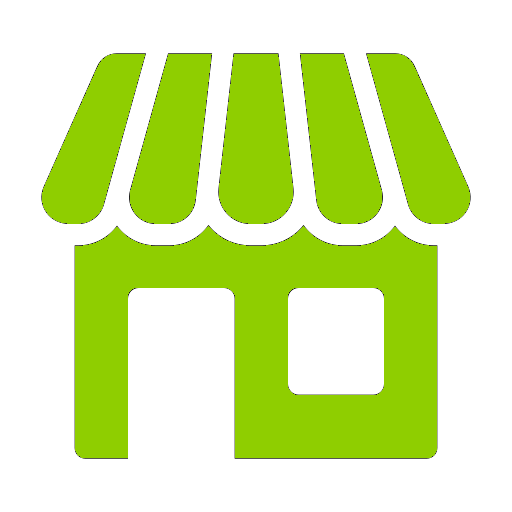
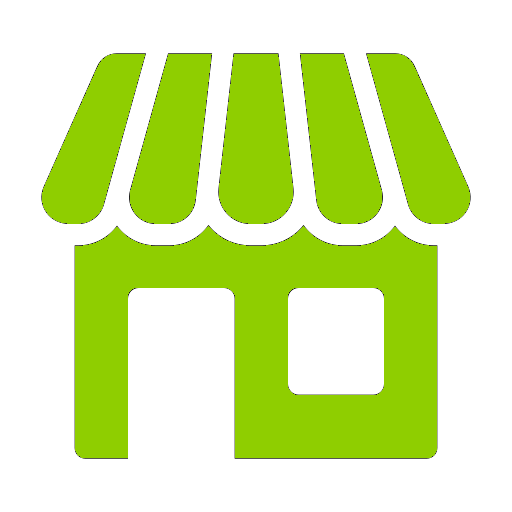
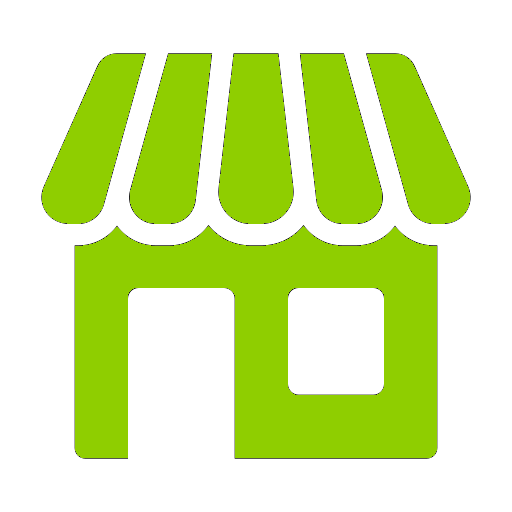
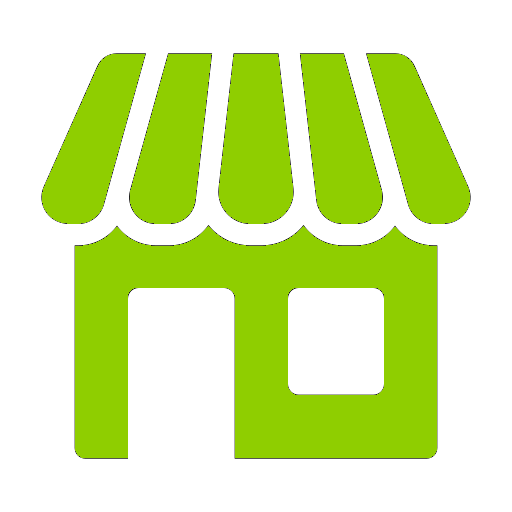
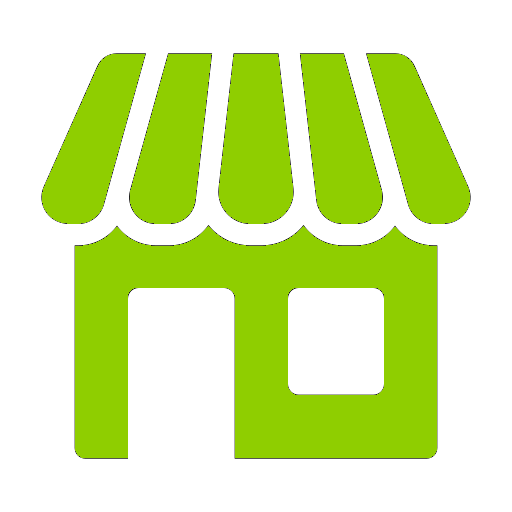
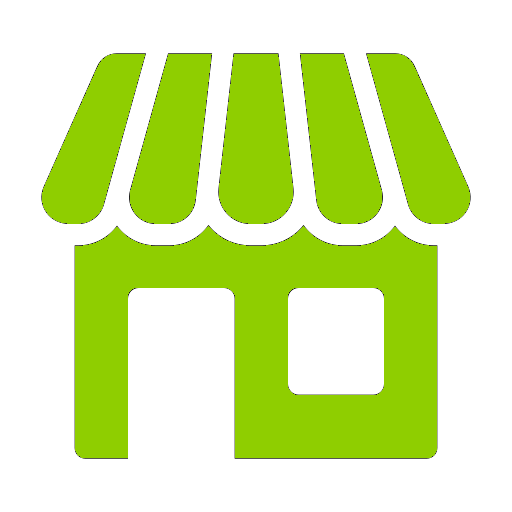
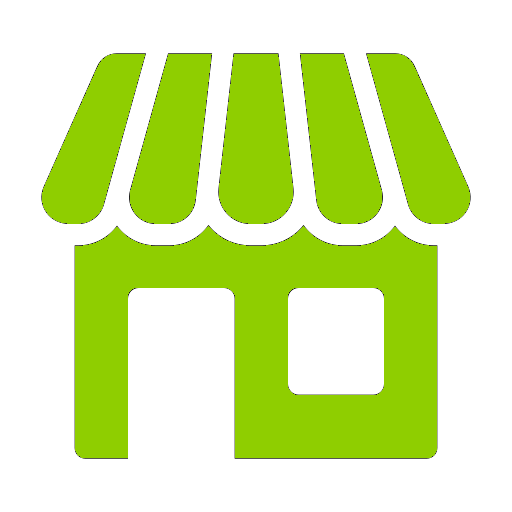
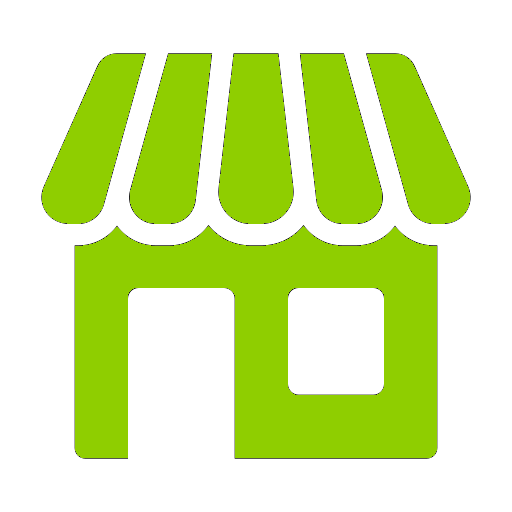
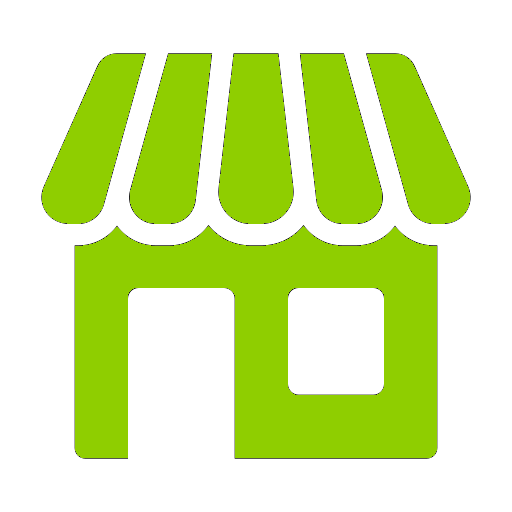
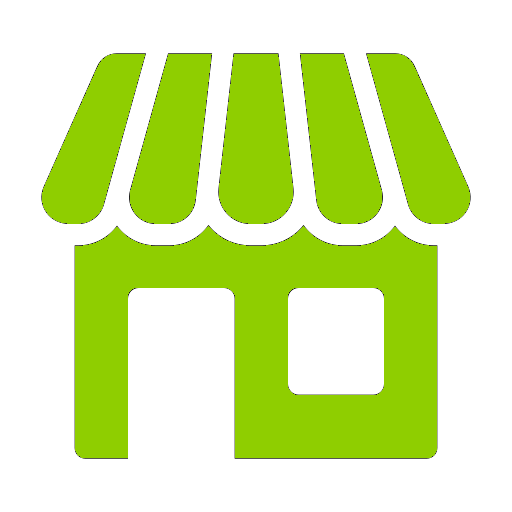
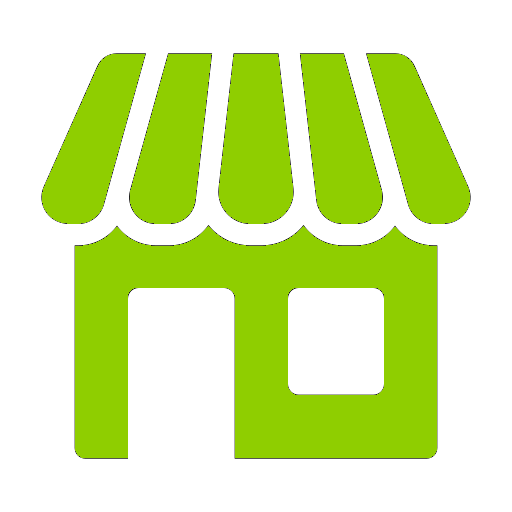
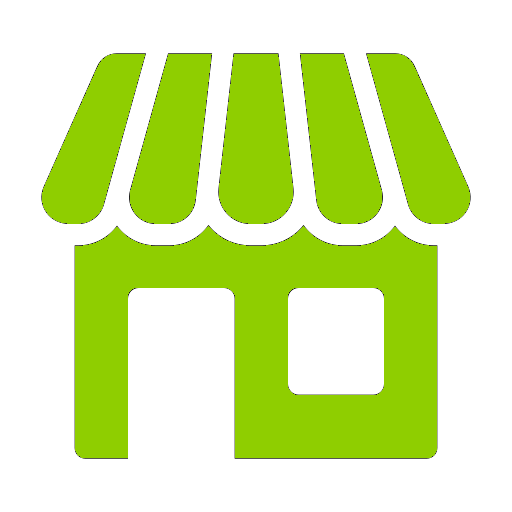
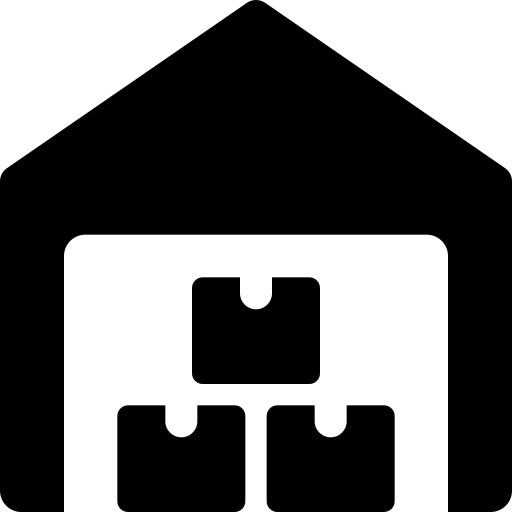

In [16]:
# plot map of weekday routes coloured by demand
weekday_map_demand = initialise_map(locations)
plot_routes(locations, selected_weekday, weekday_map_demand, col="Demand", min=min_demand, max=max_demand)